<h1 div class='alert alert-success'><center> Ponto de partida (EDA, linha de base)</center></h1>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

# Descrição de dados

Para esta competição, você vai prever se um cliente fez uma reclamação sobre uma apólice de seguro. A verdade fundamental claimtem valor binário, mas uma previsão pode ser qualquer número de 0.0 para 1.0, representando a probabilidade de uma reclamação. Os recursos neste conjunto de dados foram tornados anônimos e podem conter valores ausentes.
arquivos

- `train.csv`: os dados de treinamento com o alvo claimcoluna
- `test.csv`: o conjunto de teste; você estará prevendo o claimpara cada linha neste arquivo
- `sample_submission.csv`:  um arquivo de envio de amostra no formato correto

# <div class="alert alert-success">  1. IMPORTAÇÕES </div> 

## 1.1. Bibliotecas 

In [1]:
import warnings
import random
import os
import gc
import torch

In [2]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import scikitplot        as skplt

In [3]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer
from sklearn.impute          import SimpleImputer
from sklearn                 import metrics

In [4]:
import xgboost               as xgb

## 1.2. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [5]:
def jupyter_setting():
    
    %matplotlib inline
      
    #os.environ["WANDB_SILENT"] = "true" 
    #plt.style.use('bmh') 
    #plt.rcParams['figure.figsize'] = [20,15]
    #plt.rcParams['font.size']      = 13
     
    pd.options.display.max_columns = None
    #pd.set_option('display.expand_frame_repr', False)

    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    #warnings.filterwarnings(category=UserWarning)

    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    #warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

    pd.set_option('display.max_rows', 150)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    return icecream

icecream = jupyter_setting()

# Colors
dark_red = "#b20710"
black    = "#221f1f"
green    = "#009473"
myred    = '#CD5C5C'
myblue   = '#6495ED'
mygreen  = '#90EE90'

cols= [myred, myblue,mygreen]

In [6]:
colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]

In [7]:
def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()

In [8]:
def describe(df):
    var = df.columns

    # Medidas de tendência central, média e mediana 
    ct1 = pd.DataFrame(df[var].apply(np.mean)).T
    ct2 = pd.DataFrame(df[var].apply(np.median)).T

    # Dispensão - str, min , max range skew, kurtosis
    d1 = pd.DataFrame(df[var].apply(np.std)).T
    d2 = pd.DataFrame(df[var].apply(min)).T
    d3 = pd.DataFrame(df[var].apply(max)).T
    d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

    # concatenete 
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
    m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
    
    return m

In [9]:
def reduce_memory_usage(df, verbose=True):
    
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    
    for col in df.columns:
        
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
        
    return df

In [10]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for TPS 09')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

In [11]:
def confusion_plot(matrix, labels = None, title = None):
        
    labels = labels if labels else ['Negative (0)', 'Positive (1)']    
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    sns.heatmap(data        = matrix, 
                cmap        = 'Blues', 
                annot       = True, 
                fmt         = 'd',
                xticklabels = labels, 
                yticklabels = labels, 
                ax          = ax);
    
    ax.set_xlabel('\n PREVISTO', fontsize=15)
    ax.set_ylabel('REAL \n', fontsize=15)
    ax.set_title(title)
    
    plt.close();
    
    return fig;

In [12]:
!mkdir img
!mkdir Data
!mkdir Data/pkl
!mkdir Data/submission
!mkdir Data/tunning

!mkdir model
!mkdir model/preds
!mkdir model/optuna

!mkdir model/preds/test
!mkdir model/preds/test/n1
!mkdir model/preds/test/n2
!mkdir model/preds/test/n3

!mkdir model/preds/train
!mkdir model/preds/train/n1
!mkdir model/preds/train/n2
!mkdir model/preds/train/n3
!mkdir model/preds/param

J  existe uma subpasta ou um arquivo img.
J  existe uma subpasta ou um arquivo Data.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
J  existe uma subpasta ou um arquivo model.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.
A sintaxe do comando est  incorreta.


## 1.4. Carregar Dados
São dois arquivos que vamos utilizar para análise e treinanmento dos modelos, e um arquivo para submissão na competição.

- `train.csv`: arquivo com dados de treinamento;  
- `test.csv`: arquivo que será utilizado para previsão; 
- `sample_submission.csv`: arquivo utlizado para envio das previsões.  


In [14]:
path = 'Data/'
path = 'Data/'

In [15]:
%%time

df1_train     = pd.read_csv(path + 'train.csv')
df1_test      = pd.read_csv(path + 'test.csv')
df_submission = pd.read_csv(path + 'sample_submission.csv')

df1_train.shape, df1_test.shape, df_submission.shape

Wall time: 13.6 s


((600000, 102), (540000, 101), (540000, 2))

In [16]:
df1_train.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
0,0,0.106643,3.59437,132.8040,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,0.012330,1.607190,-0.318058,0.560137,2.806880,1.35114,2.535930,0.197527,0.676494,1.98979,-3.842450,0.037380,0.230322,3.33055,0.009397,0.144738,3.05131,1.30362,0.033225,-0.018284,2.748210,-0.009294,-0.036271,-0.049871,0.019484,3.898460,11.2863,1.138020,3.366880,4.94446,-0.105772,2.11345,3.452230,0.789430,1.113210,1.49157,2.440370,0.041824,3.35537,0.053691,1.701270,0.908831,0.094902,0.030219,0.597024,4.443410,1.586490,-0.068686,-0.108268,0.061044,0.046099,0.017113,-0.027551,0.019483,-0.048826,0.050748,3.729300,5.017440,4.186880,0.063342,0.121043,1.37175,4.017450,0.167613,0.039753,2.042360,-0.016614,0.107679,3.507250,0.013660,-0.097023,5.396070,0.244457,3.49184,0.113090,-0.015472,4.208790,4.106560,0.037227,-0.118814,0.067086,0.010739,1.09862,0.013331,-0.011715,0.052759,0.065400,4.211250,1.97877,0.085974,0.240496,0
1,1,0.125021,1.67336,76.5336,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,0.037706,0.331749,0.325091,0.062040,2.262150,4.33943,-0.224999,0.233586,3.381280,1.90299,0.067874,-0.051268,0.006135,2.60444,0.103441,0.067638,4.75362,1.85552,-0.181834,0.008359,3.166340,0.011850,0.022292,0.069320,0.117109,0.315276,24.4807,1.672270,-0.409067,4.95475,0.092358,2.60318,1.954690,0.005896,3.289340,2.56453,0.817706,0.025997,4.61749,1.575540,0.066105,0.681634,0.025247,0.183500,0.110038,2.746120,0.835586,0.188196,4.960640,0.136087,-0.008493,-0.015264,-0.010841,0.064584,0.102548,0.093611,0.964089,0.630422,4.307340,0.091289,-0.036360,3.61767,3.103240,0.000657,0.051302,1.924620,0.123294,-0.022671,1.548120,-0.010397,0.058330,3.661310,-0.118386,2.35739,-0.009112,0.178701,4.097350,3.532890,0.005244,0.121381,0.109968,0.135838,3.46017,0.017054,0.124863,0.154064,0.606848,-0.267928,2.57786,-0.020877,0.024719,0
2,2,0.036330,1.49747,233.5460,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,0.056995,0.328684,2.968810,0.105244,2.069490,5.30986,1.354790,-0.262018,1.379080,1.48091,0.020542,-0.008806,0.109348,1.68365,0.038180,0.123716,1.11248,3.57166,0.120601,0.082069,2.233520,0.002270,0.045182,0.014405,0.011599,-0.502849,33.7382,1.417500,1.071350,3.22296,2.122030,3.08216,0.637555,-0.006822,-0.390943,17.34570,3.700430,-0.033600,1.57824,0.051978,-0.002004,2.690960,0.018367,-0.030468,0.111409,2.187470,-0.325000,-0.019944,3.455030,0.068105,-0.009812,-0.010627,0.027571,-0.007121,-0.048914,-0.002574,1.865090,2.404170,0.411741,0.057749,0.525174,2.16879,0.828297,0.089848,0.093744,4.949010,-0.010978,0.076671,0.266784,0.038691,0.382731,3.847600,-0.121482,3.74084,0.147098,-0.016566,0.614651,2.125840,0.078828,0.979808,0.026758,0.117310,4.88300,0.085222,0.032396,0.116092,-0.001688,-0.520069,2.14112,0.124464,0.148209,0
3,3,-0.014077,0.24600,779.9670,1.89064,0.006948,1.53112,2.69800,4.517330,4.50332,0.123494,1.002680,4.869600,0.058411,2.497850,1.23843,2.348360,0.175475,1.608890,2.02881,0.042086,0.005141,0.076506,1.65122,0.111813,0.121641,0.58912,4.23692,-0.032843,0.058168,0.712927,0.097465,0.072744,0.000324,0.063362,4.063820,25.3824,0.576572,2.026210,2.96843,1.085670,1.71088,1.371820,0.034631,0.722607,71.44850,3.034580,0.092245,3.45310,0.044829,0.027195,4.082850,0.046955,0.063695,0.029225,0.672022,0.185311,0.164284,3.804560,0.062306,-0.021406,0.009471,0.110884,0.026837,2.931160,0.068112,-0.495192,1.345280,2.242750,0.035611,-0.139274,4.74243,3.292740,0.117877,0.065605,0.556711,-0.058029,0.070501,1.101250,0.068559,0.162928,4.070180,-0.008835,3.89678,0.913739,-0.163204,3.074850,4.356780,-0.048894,4.917990,0.069930,-0.015347,3.47439,-0.017103,-0.008100,0.062013,0.041193,0.511657,1.96860,0.04001

In [17]:
df1_test.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,600000,0.003229,4.838660,585.529,2.282910,0.713180,3.907830,0.480696,1.482270,4.891810,0.056351,4.200990,3.151800,0.000349,1.85116,2.63889,0.746668,-0.004756,1.610300,4.11482,-0.077756,0.129446,0.053324,0.416789,0.445009,0.150464,5.021300,2.22139,-0.072333,-0.215874,1.56236,0.074881,0.010050,0.018582,0.067466,5.57830,3.08556,3.842470,0.011125,2.35997,0.695092,-0.345747,4.38817,0.054919,2.80360,3.87234,3.974520,0.157887,0.704785,-0.001126,-0.004548,1.01082,0.094506,0.016935,0.100871,4.36695,1.832040,0.019682,1.964200,0.120581,0.080247,0.027516,0.048825,0.074626,0.041264,0.069319,4.248810,2.09195,0.695042,0.007464,-0.017882,1.883500,1.268030,0.023747,0.043071,3.174780,0.074356,0.125909,3.926430,0.046914,-0.042290,3.01925,0.089564,3.20070,0.009679,-0.099653,3.573060,4.79727,0.091985,0.773543,0.073380,0.112910,1.073550,0.122149,0.086330,0.036010,0.010619,0.290343,1.898200,0.131533,0.012047
1,600001,0.008602,0.505536,-100.099,3.012670,0.027199,1.194610,5.036620,2.517440,4.553890,0.063876,0.337257,4.439690,0.013188,3.37901,3.38470,1.167400,2.246550,1.750170,2.76624,-0.058501,0.012595,0.036144,0.769057,0.017496,0.050283,0.324697,4.94864,0.124789,0.347128,1.24512,0.035822,-0.013188,0.023194,0.006444,4.98333,23.70690,8.287290,4.796230,1.79928,-0.050040,1.973320,1.91201,0.035974,2.57237,6.32126,0.442628,0.148115,1.311350,0.106667,0.626128,2.30973,-0.044350,0.194283,0.131445,4.26667,0.715653,0.017117,2.839080,0.104712,-0.007952,0.067650,0.066438,0.034258,0.606144,0.019988,-0.456704,3.37877,1.900050,0.052316,-0.050397,2.612950,3.112540,0.022305,0.108325,4.617640,0.091440,0.039368,3.035190,1.023050,-0.020578,2.77156,3.309480,5.05840,-0.003993,0.067636,0.995391,2.47165,-0.015214,0.263423,-0.021910,-0.020214,2.622340,0.123307,0.033063,0.123059,0.005771,-0.392923,3.689640,0.047418,0.120015
2,600002,1.461000,2.437260,-112.964,3.541230,0.752338,4.338310,1.648080,4.699910,1.950250,0.005303,2.071680,0.546499,0.141781,1.67317,4.30649,1.702330,-0.062869,1.619230,4.19053,0.055140,-0.016590,0.017805,3.064810,0.070370,0.098316,3.507540,1.06910,0.012750,0.009981,3.46781,0.035920,-0.009804,0.065728,-0.004725,5.28102,11.52880,0.171694,4.394570,2.52084,0.079365,5.451320,1.78582,0.029620,3.06383,5.27599,0.315972,0.148310,0.463193,-0.039962,0.150592,3.75460,0.024164,0.107455,0.048741,3.58240,0.966391,-0.058947,1.869830,0.029872,-0.044294,0.065172,-0.003328,-0.001950,0.095007,0.080267,3.337300,3.60489,4.694580,0.075650,-0.088276,1.772440,-0.142226,0.000918,0.021483,0.241844,0.067591,-0.026572,0.894909,0.111606,0.524423,1.45007,0.019355,1.27135,0.076042,0.446993,4.406990,2.44697,-0.041154,0.212414,0.141005,-0.011036,2.030180,-0.000426,0.084091,0.123605,0.499554,4.054650,3.330670,0.108843,0.064687
3,600003,0.140556,3.085610,179.451,0.573945,0.057342,2.216790,1.623480,0.526174,1.542540,-0.026160,1.609440,1.723560,-0.019564,1.55213,4.83264,1.501640,0.192669,4.614890,1.47069,-0.010031,0.072805,0.048035,3.230210,-0.031548,0.028697,3.752520,4.94847,-0.174542,-0.033491,2.47823,0.068129,0.090797,0.029877,0.146718,3.16983,-12.98460,3.135210,1.765010,3.25399,0.713238,3.729920,2.65153,0.080945,1.05649,1.45260,1.814190,0.077875,2.721310,0.004530,0.108844,2.83445,0.024642,-0.051423,0.060574,3.42020,1.283600,-0.083213,0.048820,-0.002502,0.051387,0.075775,-0.008900,0.141776,0.173123,0.012894,3.390590,2.69899,0.059916,0.055400,-0.000140,2.641440,0.839721,-0.026268,0.058745,2.521910,0.118737,0.134899,2.839480,0.108751,-0.015848,1.14724,0.390064,3.30923,-0.046117,-0.206052,2.373770,3.15941,0.131234,1.031180,0.026155,0.050117,0.221613,0.045298,0.129966,0.004015,0.018279,2.696580,-0.533491,

# <div class="alert alert-success">  1.0. Análise Exploratória de Dados (EDA)  </div> 

### 1.1.2. Dimensão do DataSet

In [18]:
print('TREINO')
print('Number of Rows: {}'.format(df1_train.shape[0]))
print('Number of Columns: {}'.format(df1_train.shape[1]), end='\n\n')

print('TESTE')
print('Number of Rows: {}'.format(df1_test.shape[0]))
print('Number of Columns: {}'.format(df1_test.shape[1]))

TREINO
Number of Rows: 600000
Number of Columns: 102

TESTE
Number of Rows: 540000
Number of Columns: 101


### 1.1.3. Tipo de Dados

In [19]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 102 entries, id to target
dtypes: float64(100), int64(2)
memory usage: 466.9 MB


In [20]:
df1_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540000 entries, 0 to 539999
Columns: 101 entries, id to f99
dtypes: float64(100), int64(1)
memory usage: 416.1 MB


In [21]:
print(f'{3*"="} For Pandas {10*"="}\n{(df1_train.dtypes).value_counts()}')
print(f'\n{3*"="} For Datatable {7*"="}\n{(df1_test.dtypes).value_counts()}')

=== For Pandas ==========
float64    100
int64        2
dtype: int64

=== For Datatable =======
float64    100
int64        1
dtype: int64


<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <BR>
    
- O dataset de treiro tem 466.9 MB com 600000 de registros e 102 columas; 
- O dataset de teste tem 416.1 com 540000 de registros e 101 columas
   
    
Vamos fazer uma redução desses dataset nas próximas etapas, primeiro vamos identificar os tipos de dados que temos nos datasets.

</div>

### 1.1.4. Idenficar Variáveis Ausentes (NA)
Vamos verificar os valores ausentes em cada variável conjunto de treinono e teste.

In [22]:
missing = missing_zero_values_table(df1_train)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 102 colunas e 600000 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


In [23]:
missing = missing_zero_values_table(df1_test)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 101 colunas e 540000 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>

Não temos dados faltantes.
    
</div>

### 1.1.6. Estatística Descritiva
Abaixo estão as estatísticas básicas para cada variável que contém informações sobre contagem, média, desvio padrão, mínimo, 1º quartil, mediana, 3º quartil e máximo.

In [24]:
feature_cat   = df1_test.select_dtypes(object).columns.to_list()
feature_float = df1_test.select_dtypes(np.number).columns.to_list()

In [25]:
print('Temos {} variávies numéricas e {} categóricas.'.format(len(feature_float), len(feature_cat)))

Temos 101 variávies numéricas e 0 categóricas.


#### 1.1.6.1. Atributos Numéricos

- Train

In [26]:
df1_train[feature_float].describe().style.background_gradient(cmap='YlOrRd')

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,299999.500000,0.306508,2.497590,306.644536,2.647901,0.177850,2.556832,2.699650,2.571593,2.538273,0.134370,2.579987,2.759273,0.128958,2.477244,2.662859,2.631040,0.362479,2.483075,2.471319,0.108097,0.093783,0.062157,2.559781,0.097061,0.141055,2.580093,2.459101,0.057945,0.216789,2.471344,0.125638,0.107798,0.170434,0.054776,2.463409,55.698848,1.769510,2.595079,2.410926,0.593497,2.646091,2.582621,0.108999,2.500058,3.227368,2.595892,0.061749,2.537154,0.084997,0.244993,2.558957,0.093148,0.314877,0.109274,2.455216,2.571747,0.270019,2.604276,0.099612,0.087340,0.088858,0.144262,0.124303,0.340198,0.086385,2.513444,2.577005,2.522315,0.134467,0.189364,2.494925,2.632673,0.129834,0.050814,2.551266,0.174057,0.231822,2.420256,0.101771,0.349875,2.550175,0.902983,2.598029,0.162773,0.501982,2.587270,2.653461,0.265197,0.335756,0.056866,0.071252,2.444471,0.155260,0.059407,0.144932,0.106419,2.547853,2.590159,0.158881,0.123048
std,173205.225094,0.522450,1.554018,551.743893,1.544529,0.417488,1.562527,1.564000,1.549361,1.532988,0.421892,1.604389,1.545217,0.210861,1.517694,1.481966,1.531067,1.346352,1.577456,1.541571,0.395313,0.308938,0.054796,1.556496,0.333590,0.342377,1.609573,1.567891,0.114129,0.339320,1.524330,0.296563,0.412291,0.440615,0.109661,1.566572,130.132892,1.785712,1.562506,1.572078,0.951892,1.567926,1.537063,0.356046,1.575150,5.414258,1.559765,0.365426,1.502016,0.292977,0.622615,1.611025,0.341598,0.579662,0.201639,1.533550,1.485223,0.852348,1.532116,0.590106,0.432437,0.151993,0.377962,0.414040,0.623011,0.216007,1.516342,1.563820,1.532317,0.398998,0.744550,1.575232,1.541872,0.308313,0.049142,1.513612,0.641809,1.206276,1.557891,0.245734,0.596830,1.576794,1.335611,1.542775,0.295831,2.364291,1.564173,1.546943,0.562230,0.993598,0.128607,0.112654,1.542509,0.548397,0.119426,0.462015,0.209128,1.558427,1.525091,0.436190,0.264896
min,0.000000,-3.797450,-1.223960,-1842.530000,-1.368560,-3.206210,-1.169770,-1.059310,-1.281970,-1.242020,-2.577840,-1.309730,-1.451570,-0.678145,-1.295160,-1.213890,-1.450540,-18.169600,-1.387720,-1.221020,-5.334110,-2.858550,-0.151519,-1.201070,-2.721660,-2.645250,-1.380430,-1.147260,-2.281050,-4.596700,-1.225650,-2.025710,-3.273000,-1.95

- Test

In [27]:
df1_test[feature_float].describe().style.background_gradient(cmap='YlOrRd')

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
count,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000,540000.000000
mean,869999.500000,0.348663,2.618251,263.577730,2.583735,0.211793,2.709543,2.762370,2.479384,2.549483,0.125970,2.448523,2.695141,0.136604,2.635854,2.598730,2.754481,0.493555,2.508088,2.604172,0.101624,0.108458,0.060350,2.641143,0.118522,0.136695,2.674756,2.400214,0.048289,0.199889,2.458555,0.134782,0.114827,0.207928,0.057116,2.570501,50.675850,1.795800,2.590981,2.365971,0.537017,2.577512,2.555149,0.093985,2.381777,3.468520,2.655193,0.071202,2.519125,0.097342,0.224655,2.486949,0.082286,0.224570,0.127068,2.670645,2.519244,0.213250,2.673070,0.098948,0.076539,0.090797,0.150887,0.145128,0.366380,0.073919,2.601897,2.587837,2.504257,0.152137,0.182949,2.579245,2.557280,0.132398,0.047352,2.445747,0.189376,0.212541,2.575391,0.104341,0.310834,2.529117,0.964903,2.673463,0.131304,0.659688,2.404383,2.570317,0.303057,0.318599,0.049222,0.072670,2.600771,0.154676,0.056792,0.124517,0.092847,2.442579,2.640276,0.158335,0.140386
std,155884.717018,0.566251,1.543507,496.444309,1.529646,0.468154,1.568074,1.586975,1.520741,1.520833,0.399739,1.596547,1.547146,0.210628,1.522664,1.484948,1.522300,1.561276,1.587124,1.543156,0.400931,0.377137,0.055296,1.583642,0.401020,0.336644,1.589485,1.562755,0.112816,0.326524,1.533433,0.302133,0.374073,0.514127,0.129176,1.547314,120.748928,1.829037,1.532958,1.574937,0.879636,1.577746,1.558602,0.284376,1.548452,5.237088,1.549922,0.384113,1.529850,0.326032,0.564642,1.642833,0.293115,0.501508,0.244233,1.522588,1.490234,0.748498,1.542625,0.595348,0.383428,0.161447,0.404611,0.448818,0.643930,0.196715,1.547473,1.536408,1.537031,0.421340,0.765418,1.559405,1.552050,0.323132,0.049721,1.502012,0.636132,1.157963,1.567299,0.231644,0.550013,1.567178,1.398737,1.526774,0.256931,2.866339,1.548995,1.556526,0.595756,0.977233,0.103750,0.095479,1.531937,0.546308,0.135927,0.420197,0.191741,1.567684,1.537125,0.430856,0.292759
min,600000.000000,-3.628650,-1.260150,-1764.160000,-1.370560,-3.868460,-1.180650,-1.126370,-1.284250,-1.084660,-2.692380,-1.181180,-1.219680,-0.772490,-1.319350,-1.560520,-1.423530,-18.112400,-1.310280,-1.268190,-4.790120,-3.165410,-0.138620,-1.398120,-2.542880,-2.863700,-1.256610,-1.172900,-2.127890,-4.474530,-1.371920,-2.023080,-2.951230,

#### 1.1.6.1. Atributos Categóricos

In [28]:
df1_train[feature_cat].columns

Index([], dtype='object')

## 1.2. Análise Gráfica

### 1.2.1. Correlação
Vamos examinar a correlação entre as variáveis.

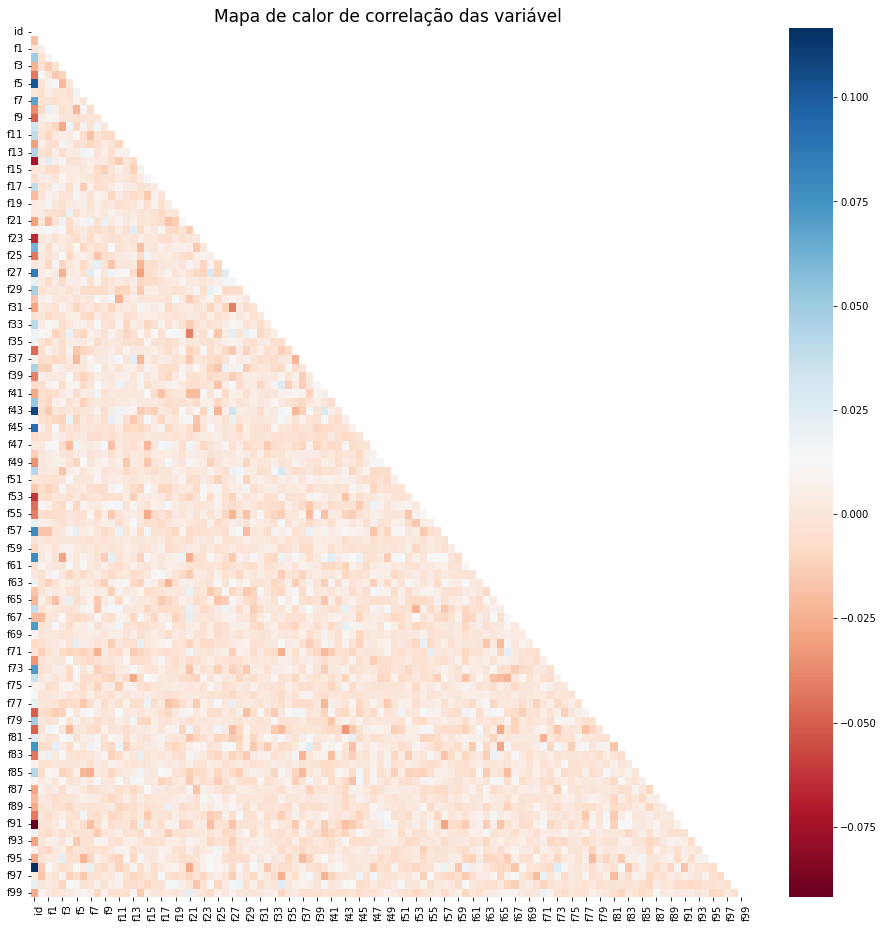

In [29]:
df = df1_train[feature_float].corr().round(5)

# Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True

# Making a plot
plt.figure(figsize=(16,16))
ax = sns.heatmap(df, annot=False, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize":13})

ax.set_title("Mapa de calor de correlação das variável", fontsize=17)

plt.setp(ax.get_xticklabels(), 
         rotation      = 90, 
         ha            = "right",
         rotation_mode = "anchor", 
         weight        = "normal")

plt.setp(ax.get_yticklabels(), 
         weight        = "normal",
         rotation_mode = "anchor", 
         rotation      = 0, 
         ha            = "right");

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
Como podemos observar, a correlação está entre -0.075 e 0.1, o que é muito pequeno, portanto, as variáveis são fracamente correlacionados.
    
</div>

### 1.2.2. Distribuição

#### 1.2.2.1. Train / Test

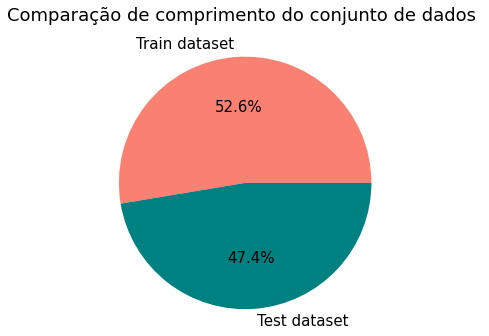

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))

pie = ax.pie([len(df1_train), len(df1_test)],
             labels   = ["Train dataset", "Test dataset"],
             colors   = ["salmon", "teal"],
             textprops= {"fontsize": 15},
             autopct  = '%1.1f%%')

ax.axis("equal")
ax.set_title("Comparação de comprimento do conjunto de dados \n", fontsize=18)
fig.set_facecolor('white')
plt.show();

#### 1.2.2.2. Proporção das variáveis

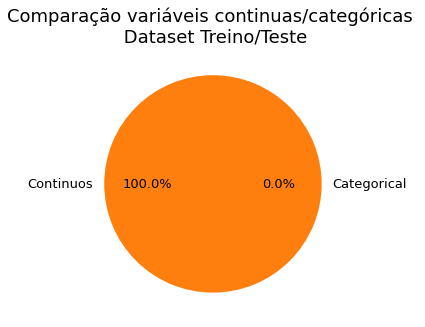

In [33]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.pie([len(feature_cat), len(feature_float)], 
        labels=['Categorical', 'Continuos'],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')

#ax.axis("equal")
ax.set_title("Comparação variáveis continuas/categóricas \n Dataset Treino/Teste", fontsize=18)
fig.set_facecolor('white')
plt.show()

#### 1.2.2.1. Target
Vamos ver as ocorrências de números individuais do conjunto de dados de treino.

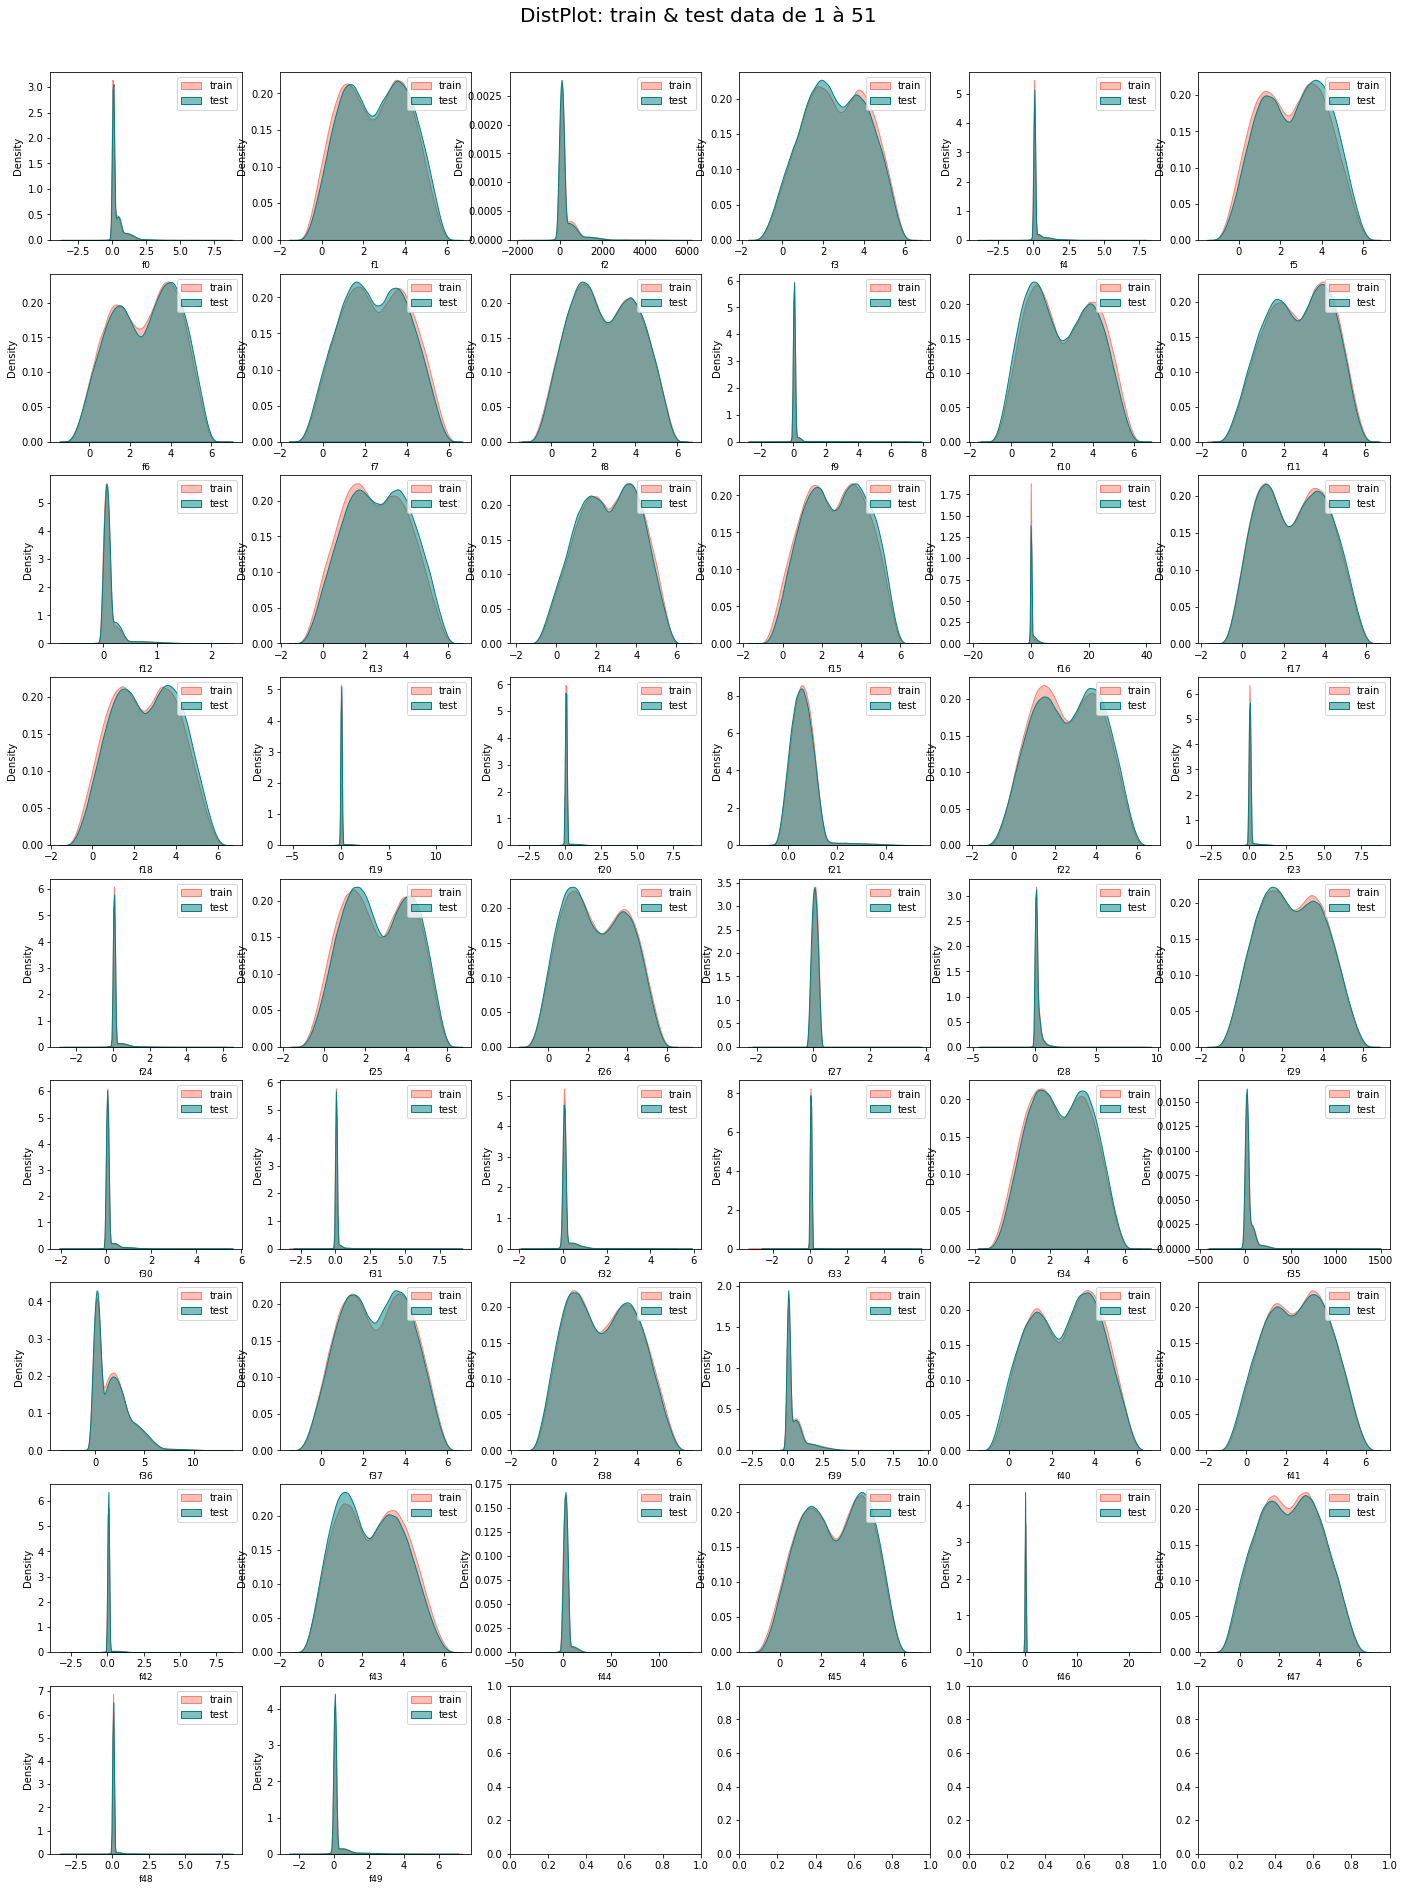

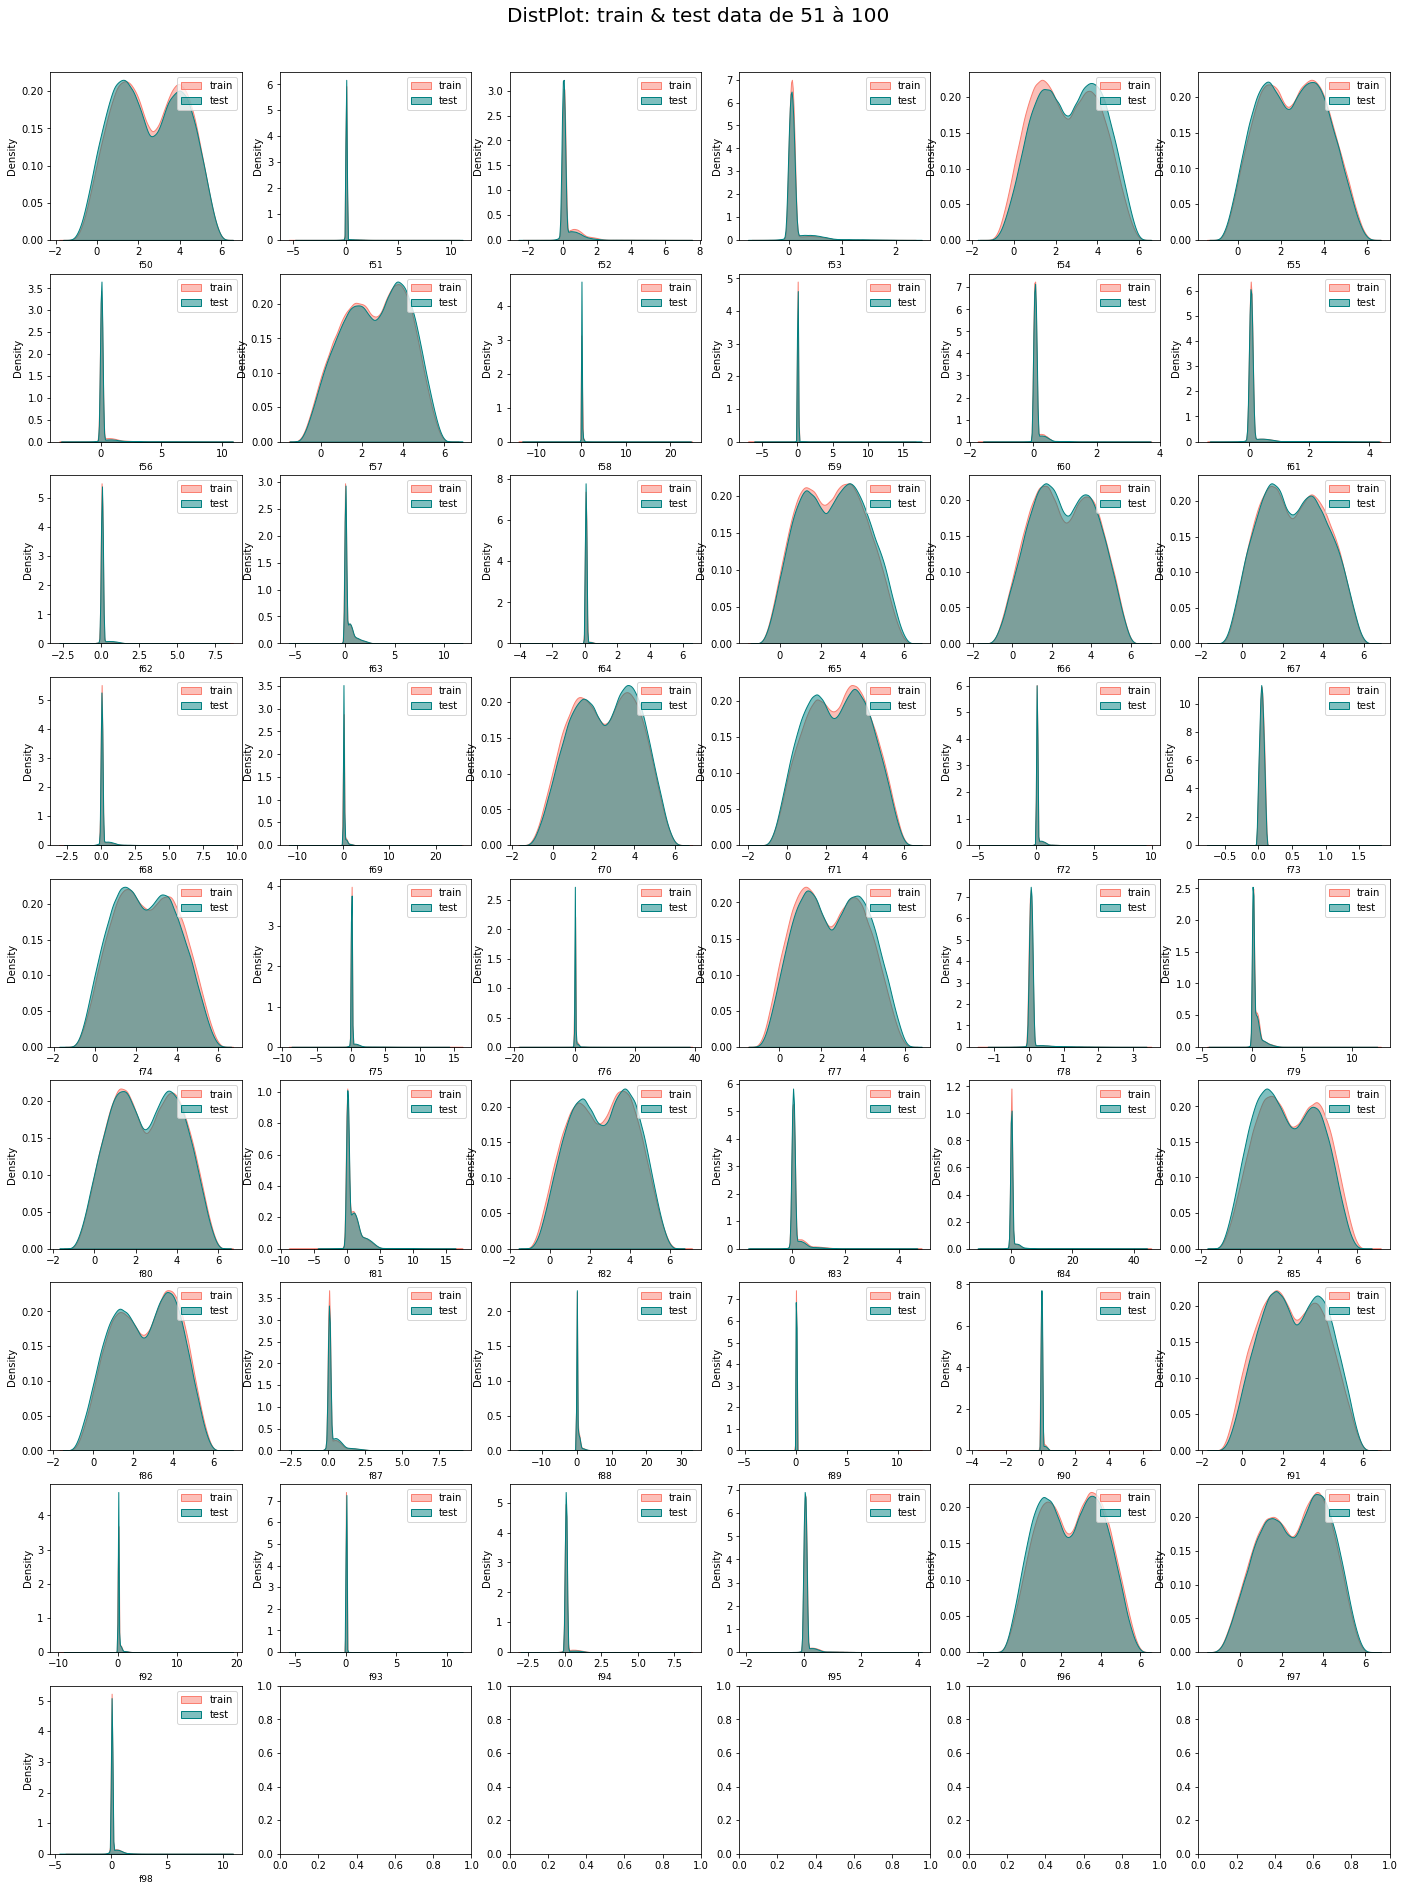

Wall time: 18min 9s


0

In [34]:
%%time 

col = [(1,51), (51,100),  ]
       
for x in col:
       
    L    = len(df1_train[feature_float].columns[x[0]:x[1]])
    nrow = int(np.ceil(L/6))
    ncol = 6
    i    = 1

    remove_last = (nrow * ncol) - L
    fig, ax     = plt.subplots(nrow, ncol,figsize=(24, 30))
    
    fig.subplots_adjust(top=0.95)
    
    for feature in df1_train[feature_float].columns[x[0]:x[1]]:

        plt.subplot(nrow, ncol, i)

        ax = sns.kdeplot(df1_train[feature], shade=True, color='salmon',  alpha=0.5, label='train')
        ax = sns.kdeplot(df1_test[feature], shade=True, color='teal',  alpha=0.5, label='test')
        plt.xlabel(feature, fontsize=9)
        plt.legend()

        i += 1
        
        gc.collect()
    
    plt.suptitle('DistPlot: train & test data de {} à {}'.format(x[0],x[1]), fontsize=20)
    plt.show()
    
    gc.collect()
    
gc.collect()

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>

- Os conjuntos de treinamento e teste têm aproximadamente as mesma distribuição em termos de variáveis; <br>
- Temos poucas variáveis com distribuição normal; <br>
- A maioria das variáveis tem distribuições distorcidas. <br>

</div>

#### 1.2.2.1. Detecção de Outlier

##### 1.2.2.1.1. Data Train 

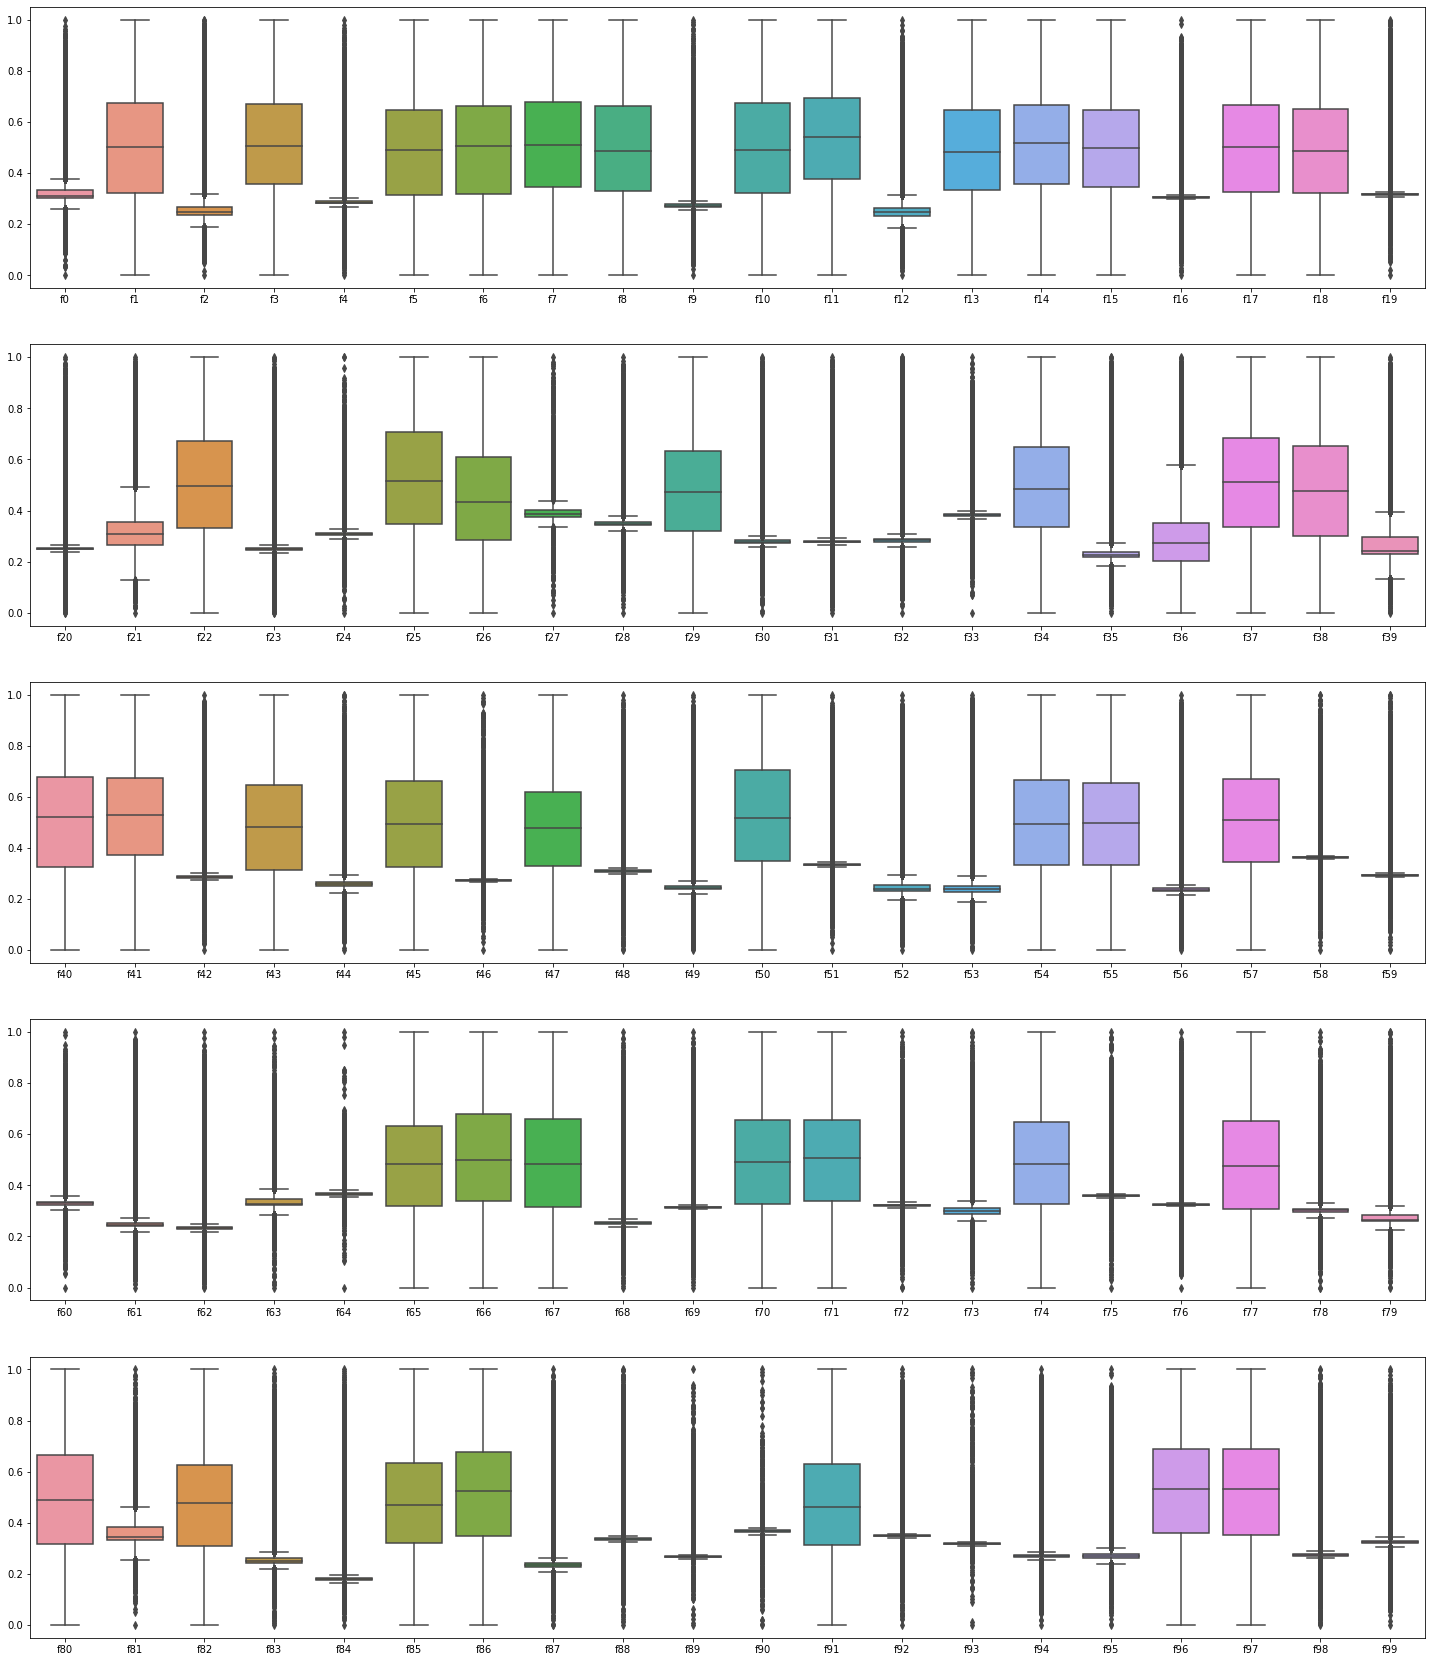

In [35]:
col = [(1,21), (21,41), (41,61), (61,81), (81,101)]

df_plot = ((df1_train[feature_float] - df1_train[feature_float].min())/
           (df1_train[feature_float].max() - df1_train[feature_float].min()))

fig, ax = plt.subplots(len(col), 1, figsize=(25,30))

for i, (x) in enumerate(col): 
    sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]);
    gc.collect()

##### 1.2.2.1.2. Data Test

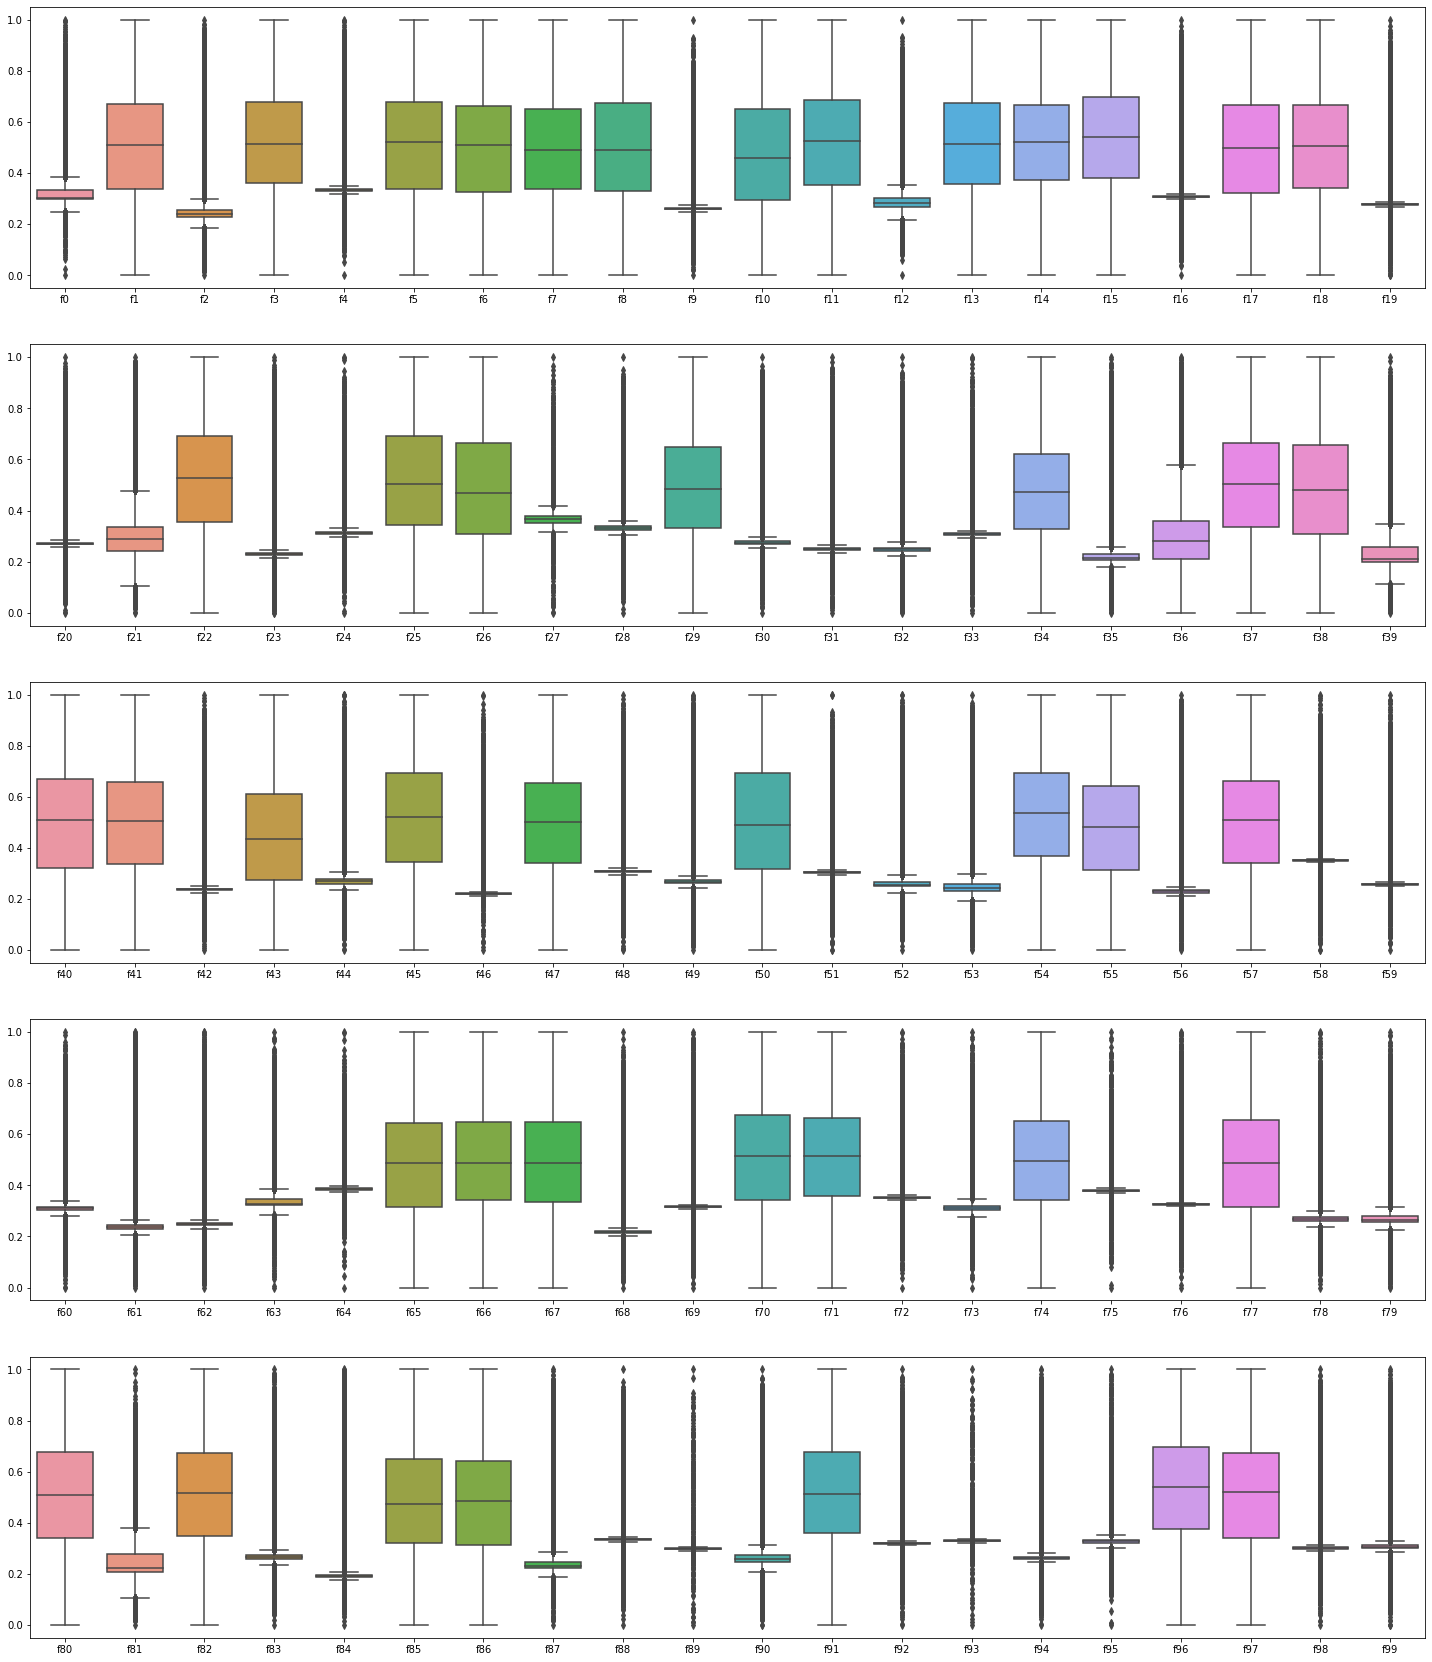

In [36]:
col = [(1,21), (21,41), (41,61), (61,81), (81,101)]

df_plot = ((df1_test[feature_float] - df1_test[feature_float].min())/
           (df1_test[feature_float].max() - df1_test[feature_float].min()))

fig, ax = plt.subplots(len(col), 1, figsize=(25,30))

for i, (x) in enumerate(col): 
    sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]);
    gc.collect()    
    

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
Acima observamos que temos muitos outliers em ambos conjunto de dados, na etapa de processamento vamos fazer o tramento ou remoção dos outliers para ajudar na previsão dos modelos. 

</div>

#### 1.2.2.3. Target
A variável alvo tem os valores 0 e 1, vamos verificar a distribuição da variável `target` que é o nosso alvo de previsão.

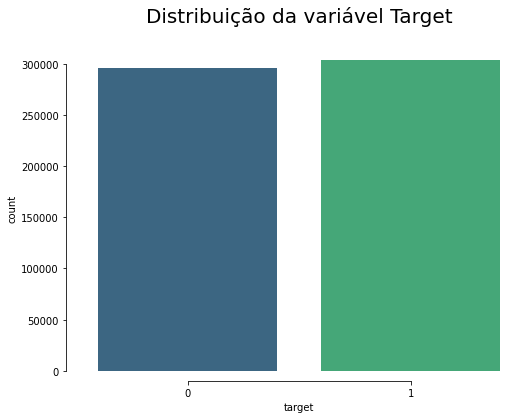

In [37]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=df1_train['target'], palette='viridis')
ax.set_title('Distribuição da variável Target', fontsize=20, y=1.05)

sns.despine(right=True)
sns.despine(offset=10, trim=True)

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
Podemos observar no gráfico acima que não temos desbalanceamento nos dados, temos mais dados na classe possitiva. 
    
</div>

#### 1.2.2.4. Variáveis preditoras  vs Target.

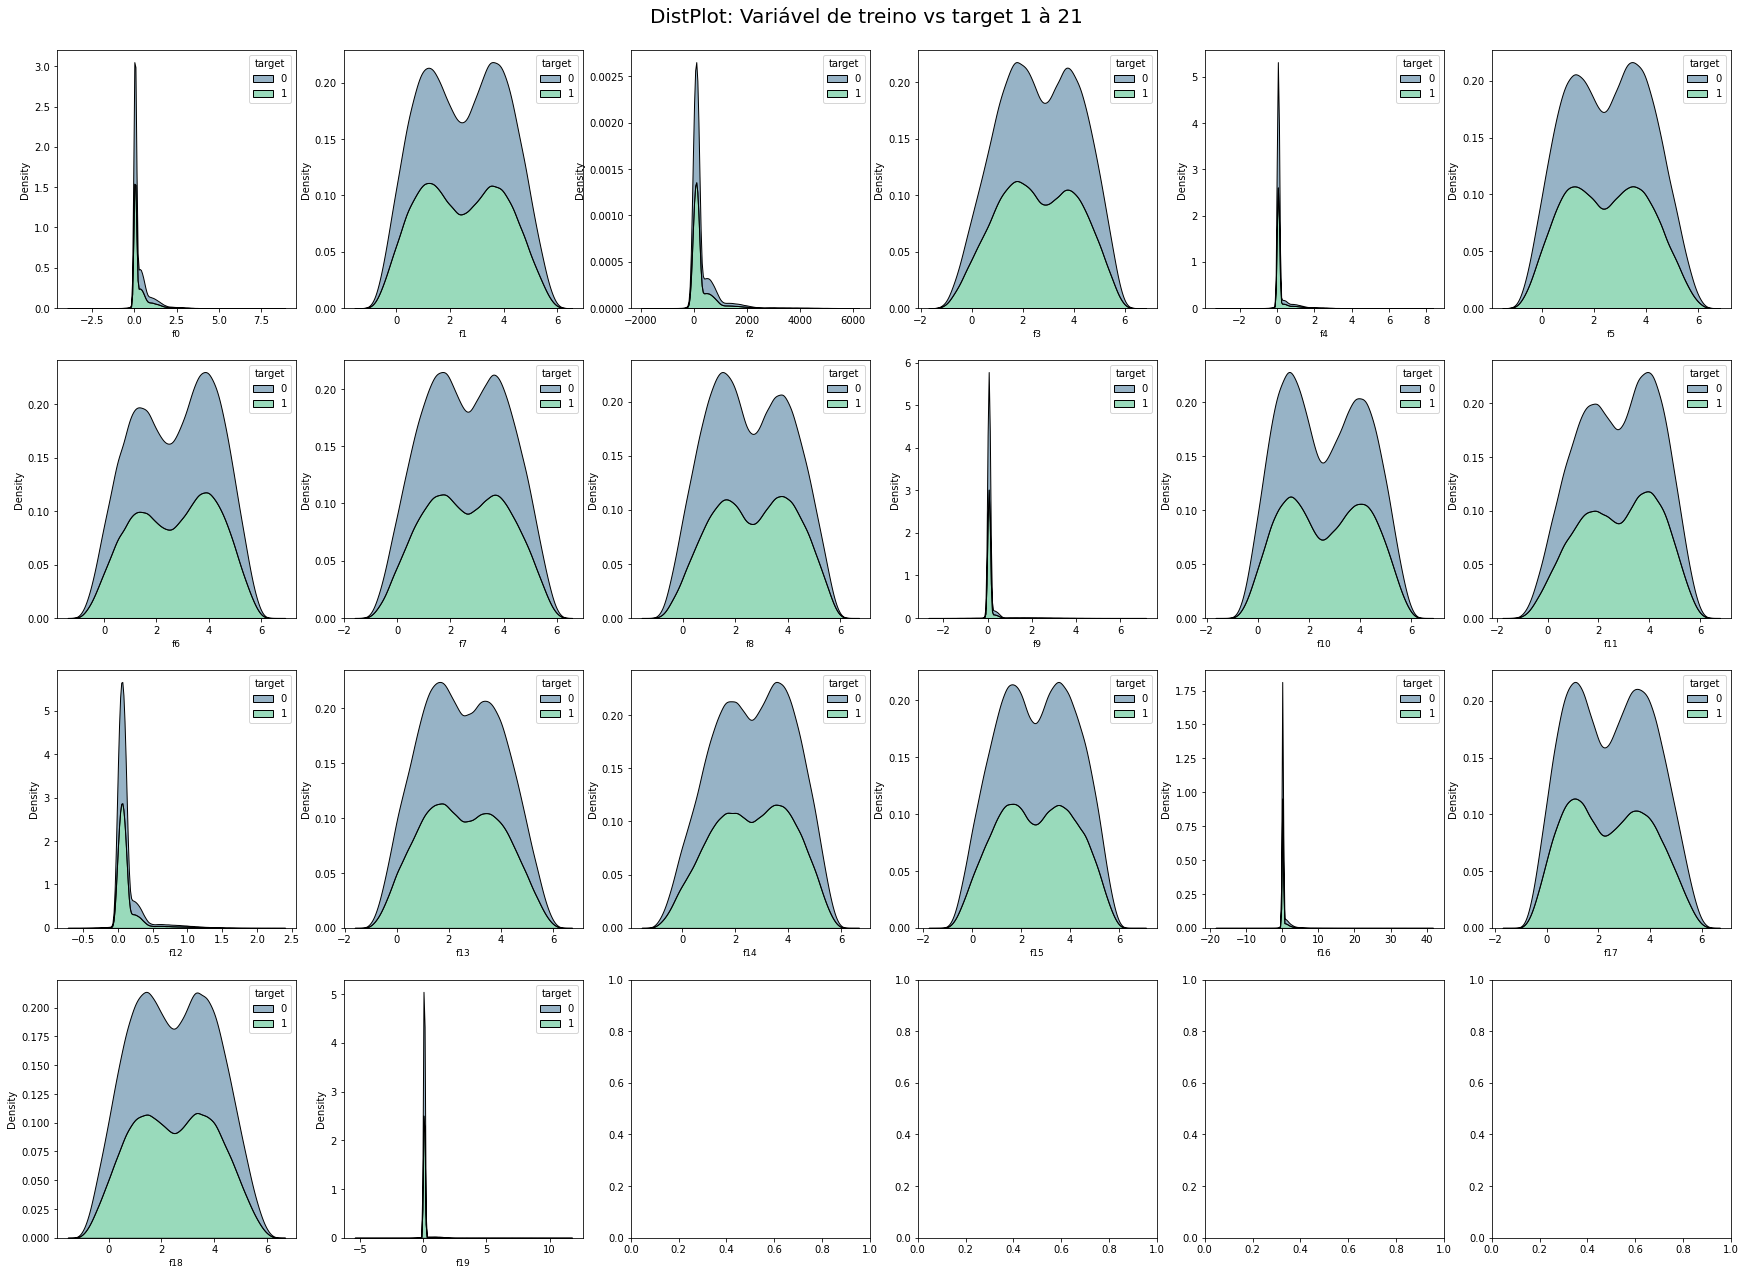

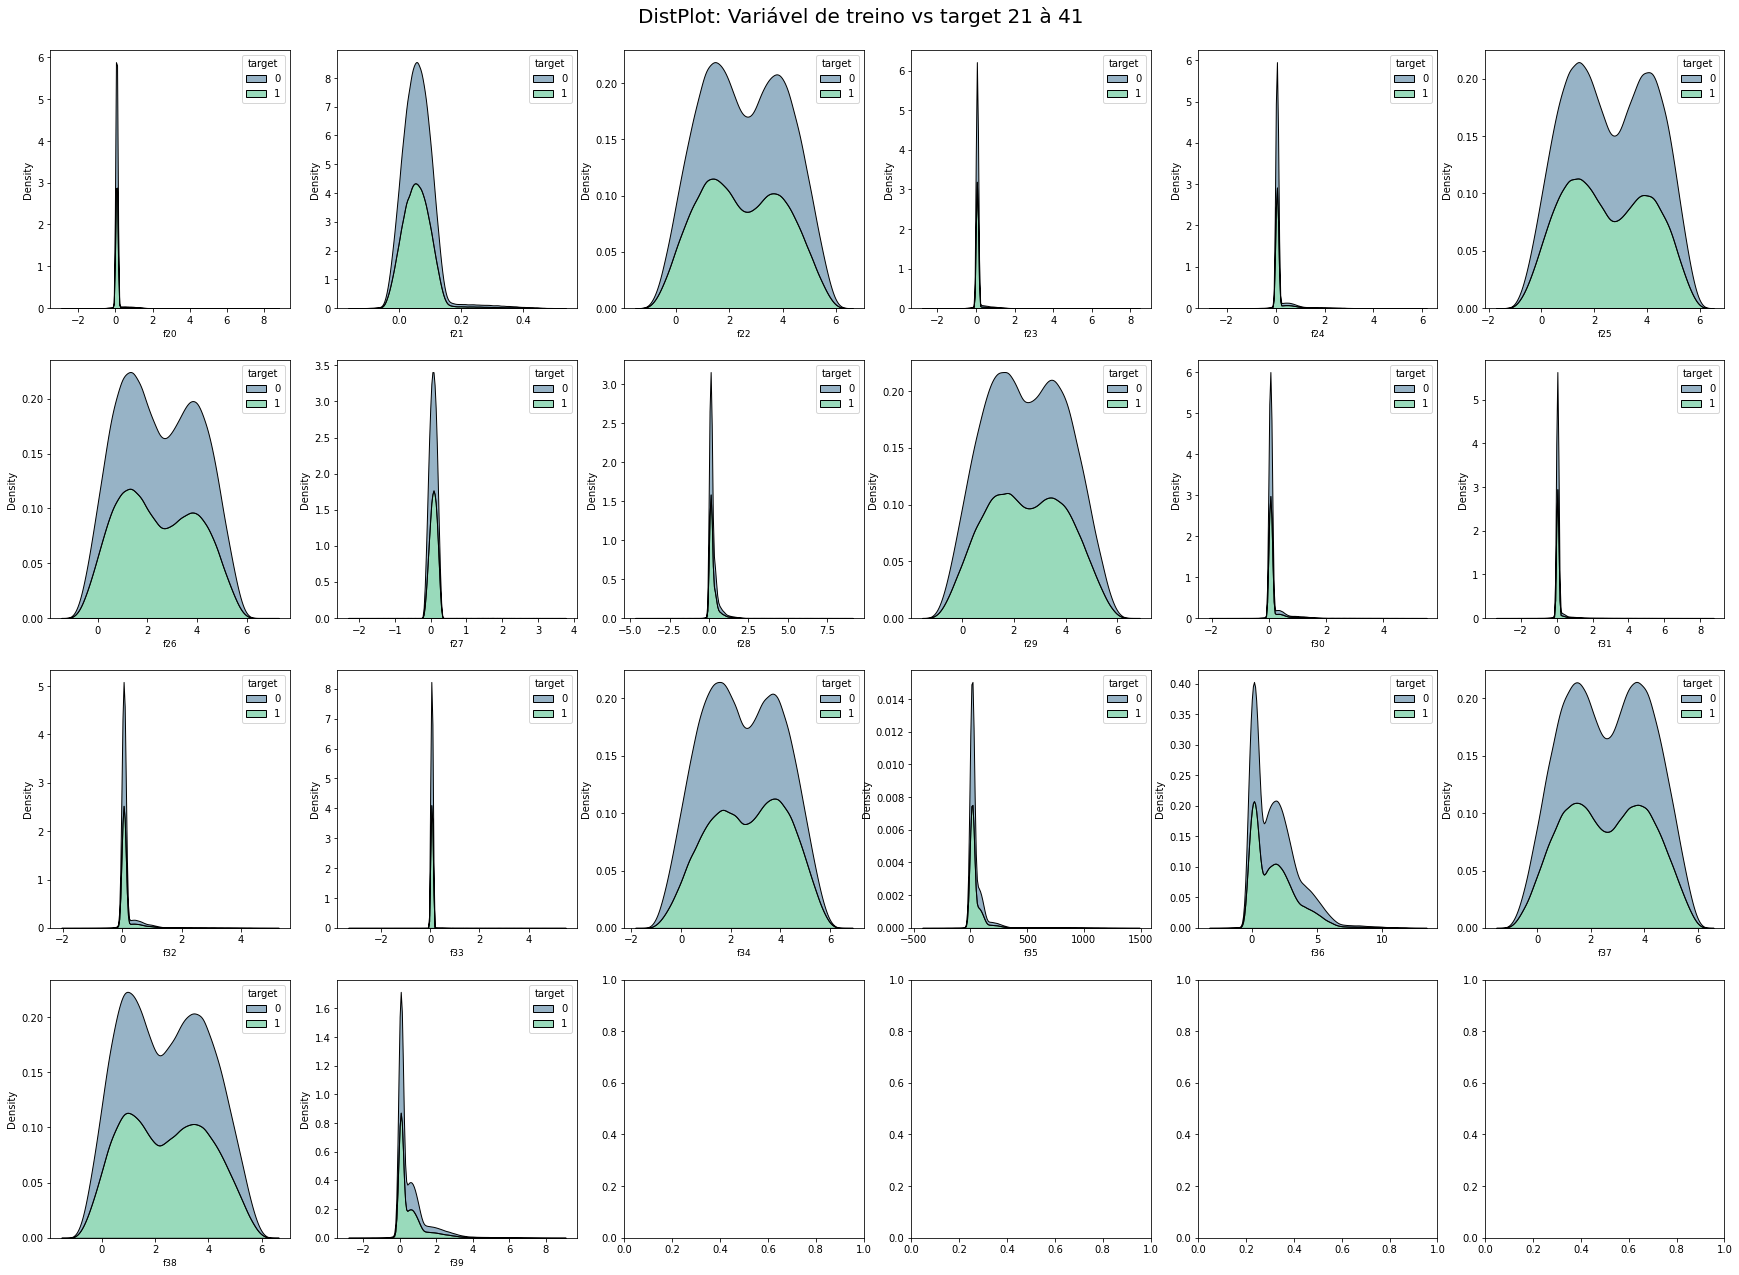

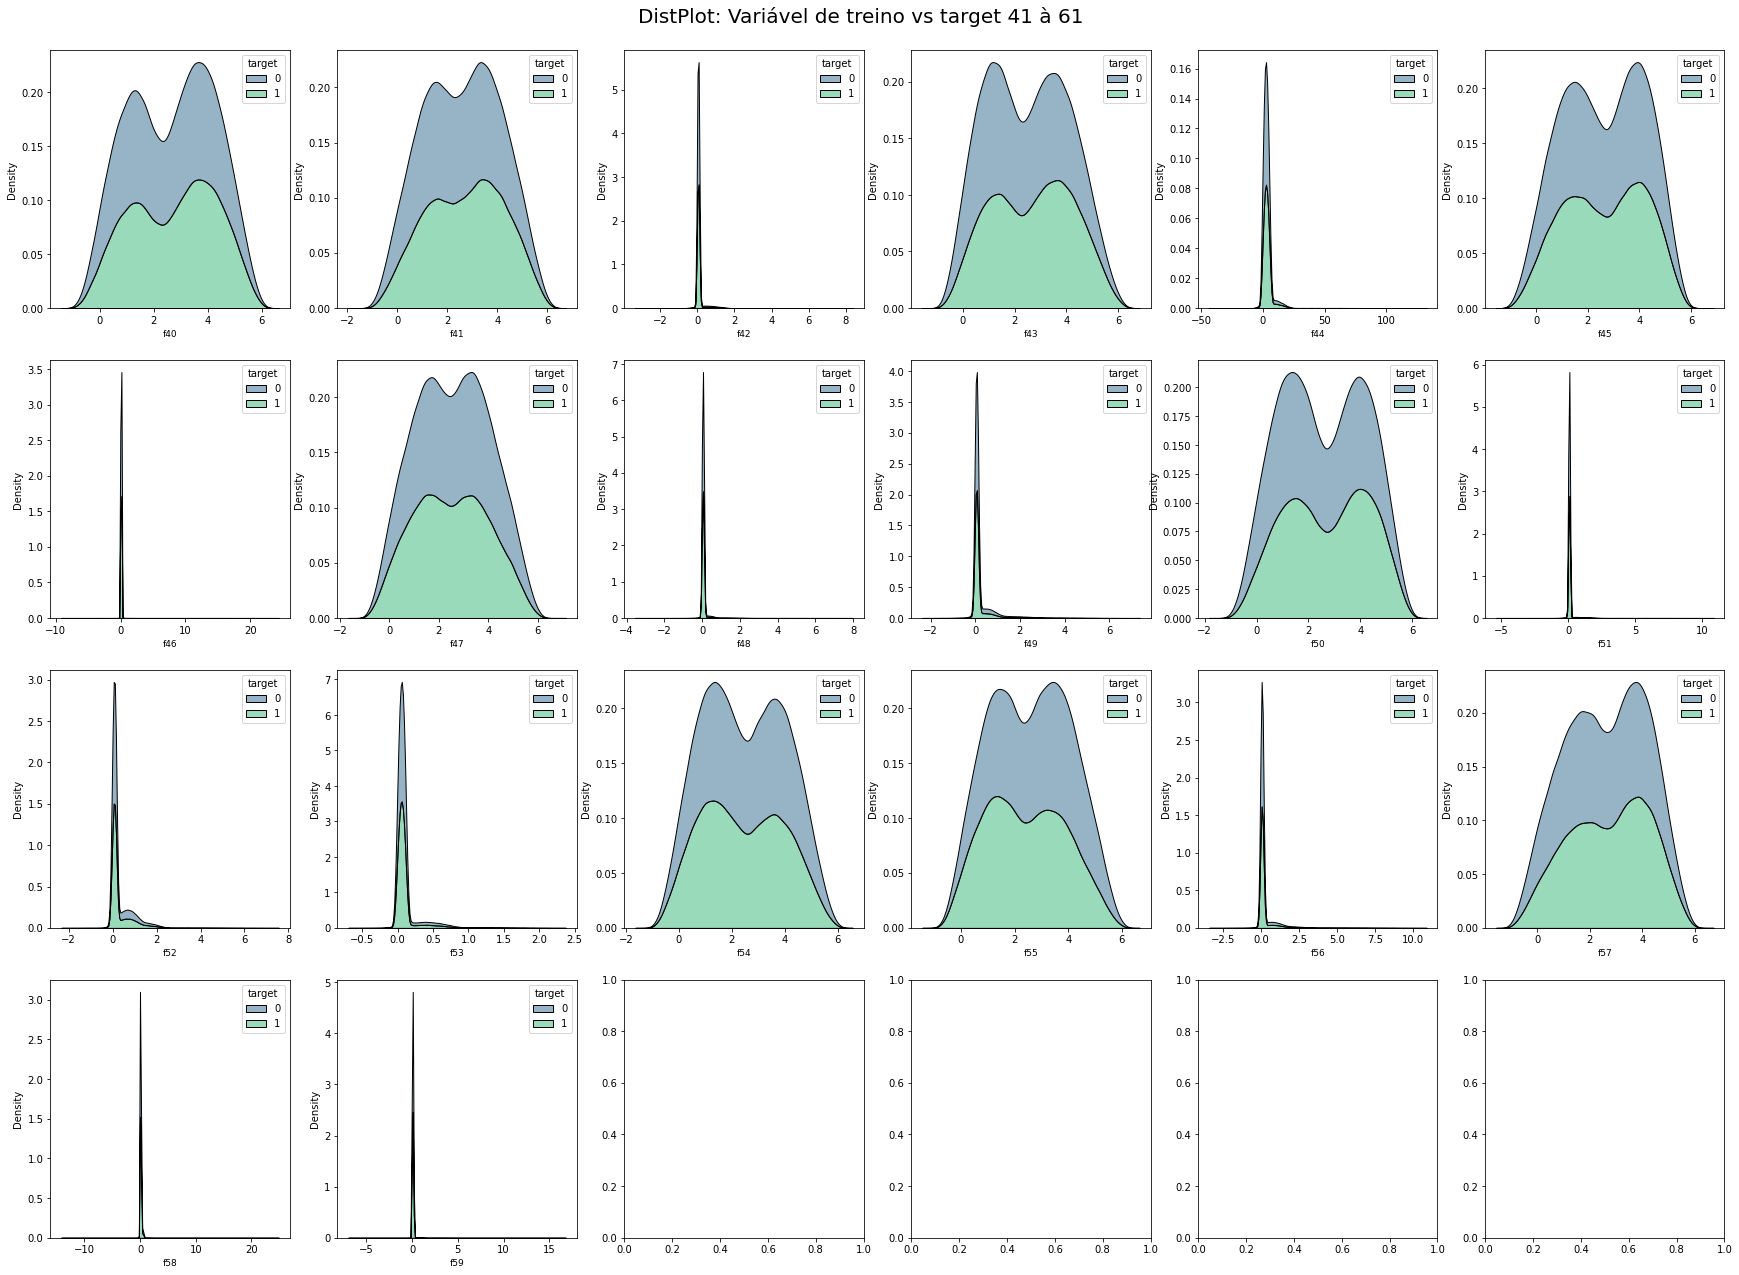

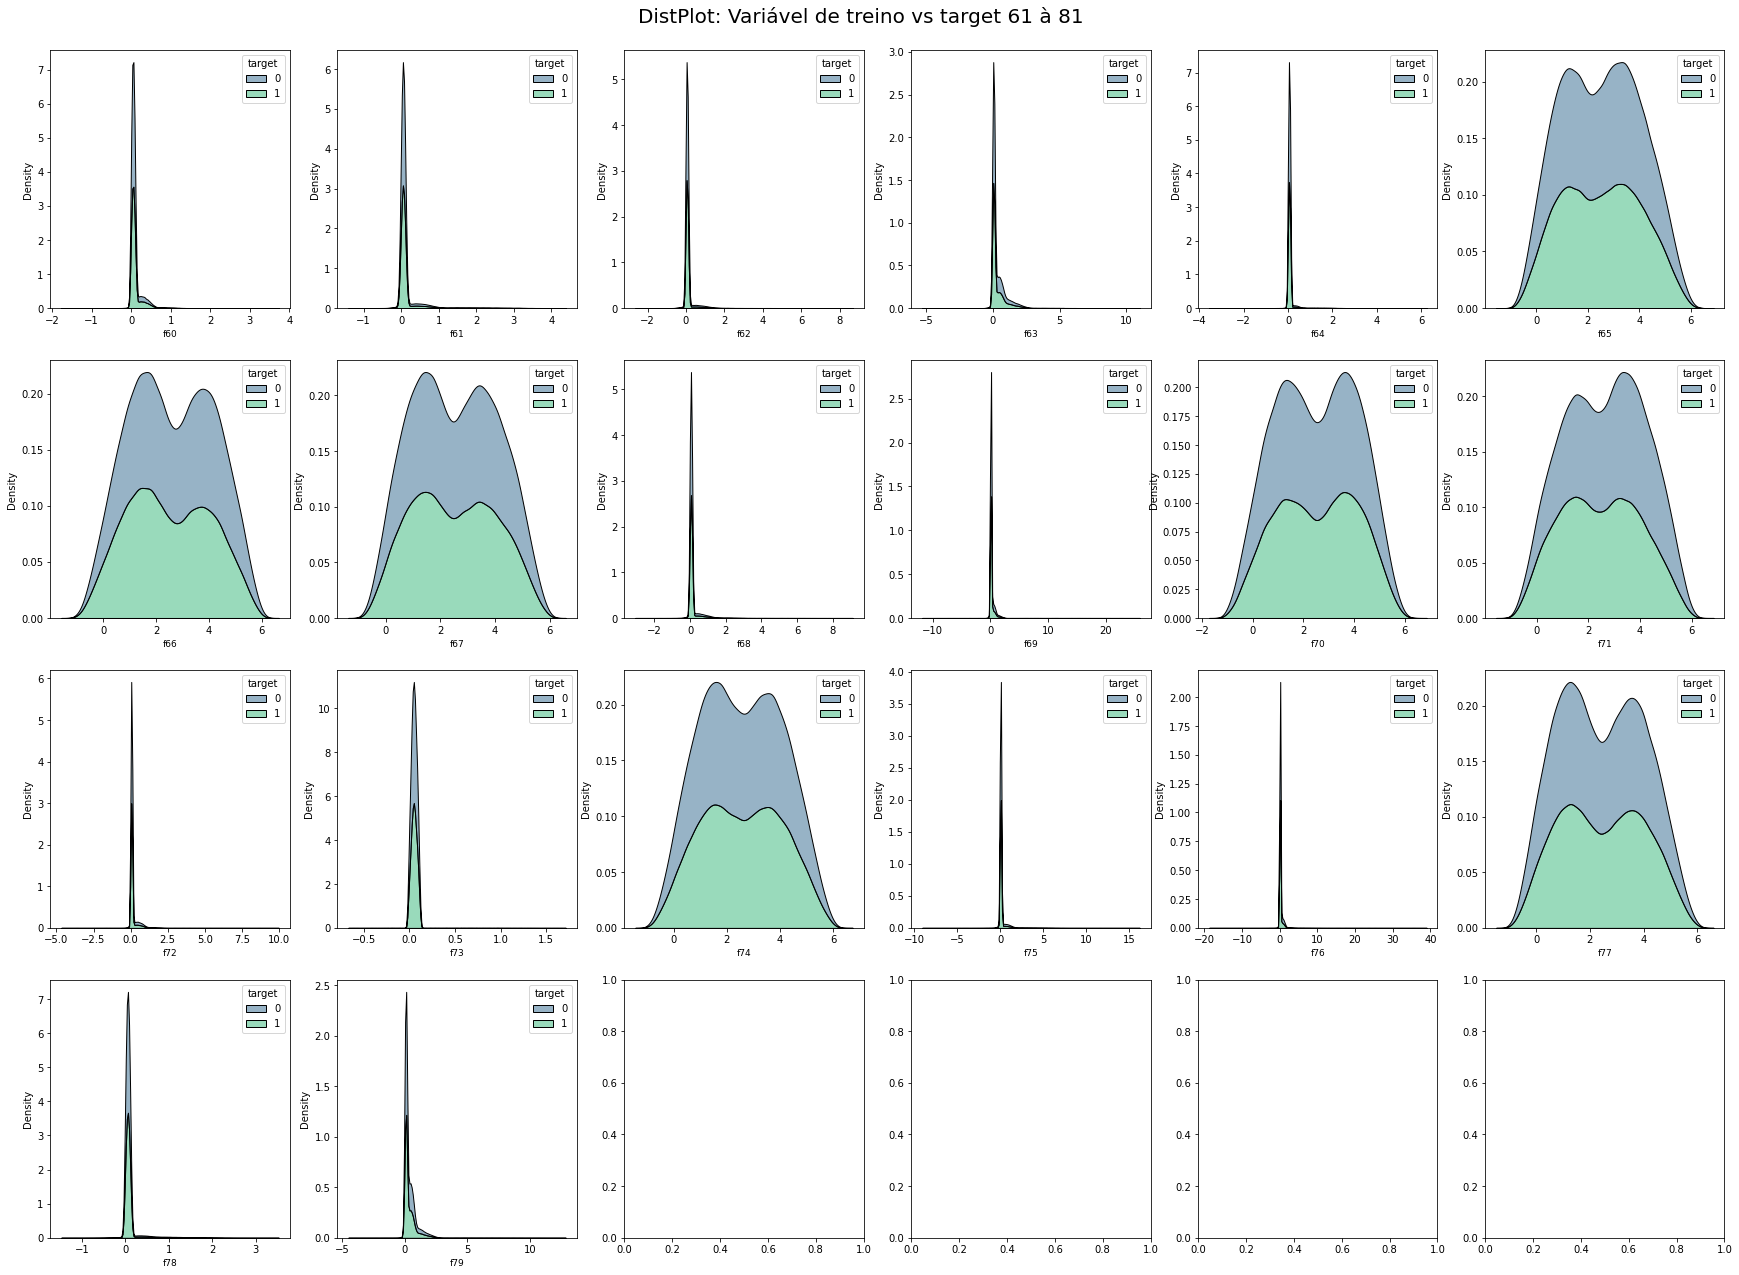

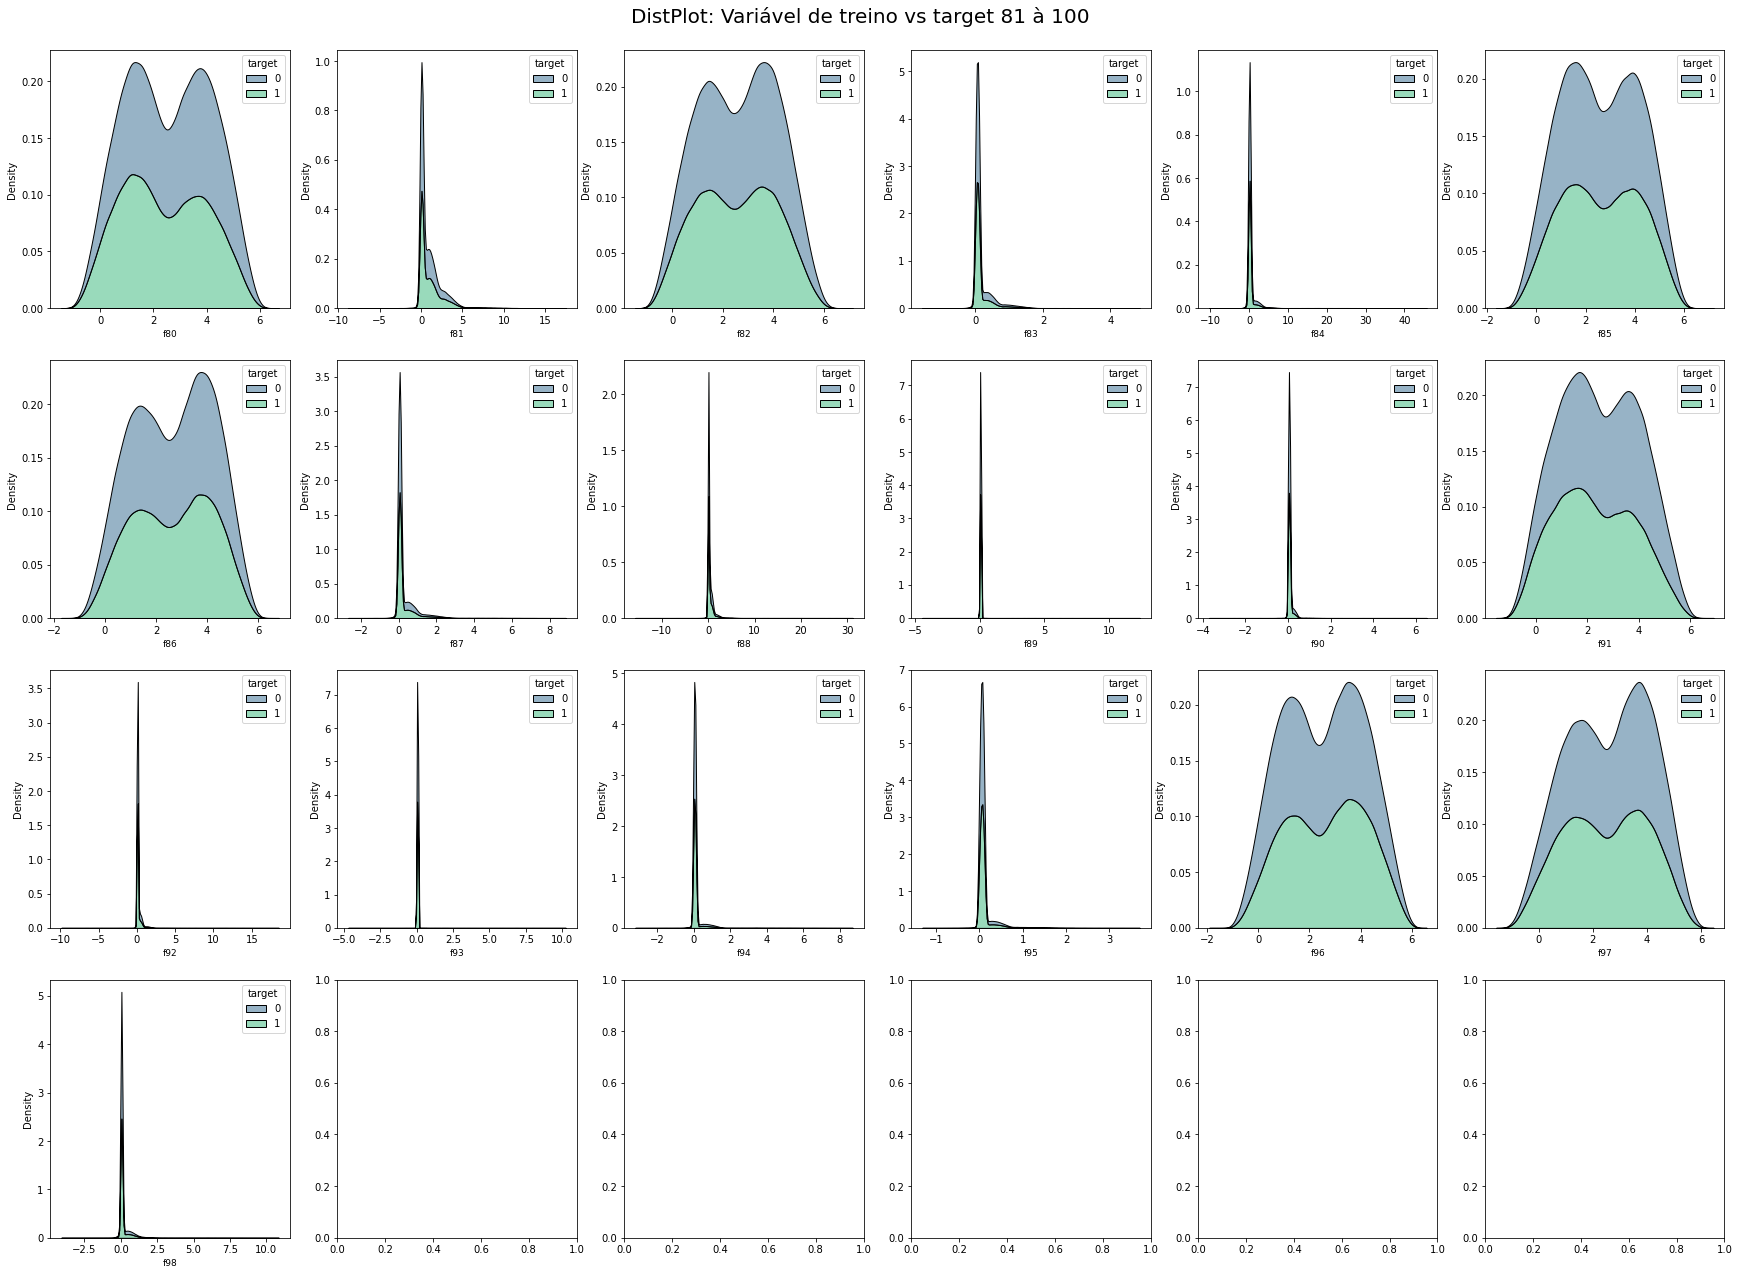

Wall time: 7min 19s


0

In [38]:
%%time 

col = [(1,21), (21,41), (41,61), (61,81), (81,100) ]
       
for x in col:
       
    L    = len(df1_train[feature_float].columns[x[0]:x[1]])
    nrow = int(np.ceil(L/6))
    ncol = 6
    i    = 1

    remove_last = (nrow * ncol) - L
    fig, ax     = plt.subplots(nrow, ncol,figsize=(30, 20))
    
    fig.subplots_adjust(top=0.95)
    
    for feature in df1_train[feature_float].columns[x[0]:x[1]]:

        plt.subplot(nrow, ncol, i)

        ax = sns.kdeplot(df1_train[feature], 
                     shade    = True, 
                     palette  = 'viridis',  
                     alpha    = 0.5, 
                     hue      = df1_train['target'], 
                     multiple = "stack")
        
        plt.xlabel(feature, fontsize=9)
       
        i += 1
        
        gc.collect()
    
    plt.suptitle('DistPlot: Variável de treino vs target {} à {}'.format(x[0],x[1]), fontsize=20)
    
    plt.show()
       
    gc.collect()
    
gc.collect()

# <div class="alert alert-success">  2. Split Train/Test </div> <br>

Antes de fazer a divisão dos dados dataset, vamos fazer a redução dos mesmo com a utlização de uma função que modifica os tipos de variáveis dos dataset, ao fazermos isso ganhamos espaço.  

In [39]:
%%time
df1_train = reduce_memory_usage(df1_train)
df1_test  = reduce_memory_usage(df1_test)

Mem. usage decreased to 117.30 Mb (0.0% reduction)
Mem. usage decreased to 105.06 Mb (0.0% reduction)
Wall time: 1.64 s


In [31]:
jb.dump(df1_train, path + 'pkl/df1_nb_01_train.pkl.z')
jb.dump(df1_test,  path + 'pkl/df1_nb_01_test.pkl.z')

['Data/pkl/df1_nb_01_test.pkl.z']

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
Tivemos uma redução em ambos datasets de 74.9%, com isso o dataset de treino passou de 466.9 MB para 117.3 Mb e no dataset de teste passou de 416.1 MB para 105.06 Mb.
    
</div>

In [40]:
gc.collect()
X      = df1_train.drop(['target', 'id'], axis=1)
y      = df1_train['target']
X_test = df1_test.drop(['id'], axis=1)
cols   = X_test.columns

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      stratify     = y,
                                                      random_state = 12359)

del df1_train,df1_test

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

((480000, 100), (480000,), (120000, 100), (120000,), (540000, 100))

In [41]:
X_test.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,0.003229,4.839844,585.5000,2.283203,0.713379,3.908203,0.480713,1.482422,4.890625,0.056335,4.199219,3.152344,0.000349,1.851562,2.638672,0.746582,-0.004757,1.610352,4.113281,-0.077759,0.129395,0.053314,0.416748,0.445068,0.150513,5.019531,2.220703,-0.072327,-0.215820,1.562500,0.074890,0.010048,0.018585,0.067444,5.578125,3.085938,3.841797,0.011124,2.359375,0.695312,-0.345703,4.386719,0.054932,2.802734,3.873047,3.974609,0.157837,0.704590,-0.001125,-0.004547,1.010742,0.094482,0.016937,0.100891,4.367188,1.832031,0.019684,1.963867,0.120605,0.080261,0.027512,0.048828,0.074646,0.041260,0.069336,4.250000,2.091797,0.694824,0.007465,-0.017883,1.883789,1.267578,0.023743,0.043060,3.173828,0.074341,0.125854,3.925781,0.046906,-0.042297,3.019531,0.089539,3.201172,0.009682,-0.099670,3.572266,4.796875,0.091980,0.773438,0.073364,0.112915,1.073242,0.122131,0.086304,0.036011,0.010620,0.290283,1.898438,0.131592,0.012047
1,0.008598,0.505371,-100.1250,3.011719,0.027206,1.194336,5.035156,2.517578,4.554688,0.063904,0.337158,4.441406,0.013191,3.378906,3.384766,1.166992,2.246094,1.750000,2.765625,-0.058502,0.012596,0.036133,0.769043,0.017502,0.050293,0.324707,4.949219,0.124817,0.347168,1.245117,0.035828,-0.013191,0.023193,0.006443,4.984375,23.703125,8.289062,4.796875,1.798828,-0.050049,1.973633,1.912109,0.035980,2.572266,6.320312,0.442627,0.148071,1.311523,0.106689,0.625977,2.310547,-0.044342,0.194336,0.131470,4.265625,0.715820,0.017120,2.839844,0.104736,-0.007950,0.067627,0.066467,0.034271,0.605957,0.019989,-0.456787,3.378906,1.900391,0.052307,-0.050385,2.613281,3.113281,0.022308,0.108337,4.617188,0.091431,0.039368,3.035156,1.023438,-0.020584,2.771484,3.308594,5.058594,-0.003994,0.067627,0.995605,2.470703,-0.015213,0.263428,-0.021912,-0.020218,2.623047,0.123291,0.033051,0.123047,0.005772,-0.392822,3.689453,0.047424,0.119995
2,1.460938,2.437500,-112.9375,3.541016,0.752441,4.339844,1.648438,4.699219,1.950195,0.005302,2.072266,0.546387,0.141724,1.672852,4.304688,1.702148,-0.062866,1.619141,4.191406,0.055145,-0.016586,0.017807,3.064453,0.070374,0.098328,3.507812,1.069336,0.012749,0.009979,3.468750,0.035919,-0.009804,0.065735,-0.004726,5.281250,11.531250,0.171753,4.394531,2.521484,0.079346,5.453125,1.786133,0.029617,3.064453,5.277344,0.315918,0.148315,0.463135,-0.039948,0.150635,3.753906,0.024170,0.107483,0.048737,3.582031,0.966309,-0.058960,1.870117,0.029877,-0.044281,0.065186,-0.003328,-0.001950,0.095032,0.080261,3.337891,3.605469,4.695312,0.075623,-0.088257,1.772461,-0.142212,0.000918,0.021484,0.241821,0.067566,-0.026566,0.895020,0.111633,0.524414,1.450195,0.019348,1.271484,0.076050,0.447021,4.406250,2.447266,-0.041168,0.212402,0.140991,-0.011032,2.029297,-0.000426,0.084106,0.123596,0.499512,4.054688,3.330078,0.108826,0.064697
3,0.140503,3.085938,179.5000,0.573730,0.057343,2.216797,1.623047,0.526367,1.542969,-0.026154,1.609375,1.723633,-0.019562,1.551758,4.832031,1.501953,0.192627,4.613281,1.470703,-0.010033,0.072815,0.048035,3.230469,-0.031555,0.028702,3.751953,4.949219,-0.174561,-0.033478,2.478516,0.068115,0.090820,0.029877,0.146729,3.169922,-12.984375,3.134766,1.764648,3.253906,0.713379,3.730469,2.652344,0.080933,1.056641,1.452148,1.814453,0.077881,2.720703,0.004532,0.108826,2.833984,0.024643,-0.051422,0.060577,3.419922,1.283203,-0.083191,0.048828,-0.002502,0.051392,0.075806,-0.008904,0.141724,0.173096,0.012894,3.390625,2.699219,0.059906,0.055389,-0.000141,2.640625,0.839844,-0.026276,0.058746,2.521484,0.118713,0.134888,2.839844,0.108765,-0.015854,1.147461,0.390137,3.308594,-0.046112,-0.206055,2.373047,3.160156,0.131226,1.031250,0.026154,0.050110,0.221558,0.045288,0.130

# <div class="alert alert-success">  2. Modelo Baseline XGB </div> <br>

Nesta etapa do processo, vamos utilizar o **XGBClassifier** como linha de base, em relação ao tratamento dos dados vamos fazer apenas o scaler neste momento.

In [42]:
seed   = 12359
params = {'objective'     : 'binary:logistic',    
          'eval_metric'   : 'auc',
          'random_state'  : seed}

if torch.cuda.is_available():           
    params.update({'predictor'  : 'gpu_predictor', 
                   'tree_method': 'gpu_hist', 
                   'gpu_id'     :  0})

params

{'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'random_state': 12359,
 'predictor': 'gpu_predictor',
 'tree_method': 'gpu_hist',
 'gpu_id': 0}

In [43]:
%%time 

model_baseline = xgb.XGBClassifier(**params)

scalers = [None, 
           StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=0)]

for scaler in scalers: 
    
    if scaler!=None:
        X_train_s = scaler.fit_transform(X_train)
        X_valid_s = scaler.fit_transform(X_valid)
    else:
        X_train_s = X_train
        X_valid_s = X_valid
                
    model_baseline.fit(X_train_s, y_train, verbose = False)
    y_hat = model_baseline.predict_proba(X_valid_s)[:, 1]    
    auc   = metrics.roc_auc_score(y_valid, y_hat) 
    
    print('Validaçao AUC: {:2.5f} => {}'.format(auc, scaler))

    gc.collect()

print()   

Validaçao AUC: 0.72985 => None
Validaçao AUC: 0.73058 => StandardScaler()
Validaçao AUC: 0.73052 => RobustScaler()
Validaçao AUC: 0.69862 => MinMaxScaler()
Validaçao AUC: 0.73003 => MaxAbsScaler()
Validaçao AUC: 0.73057 => QuantileTransformer(output_distribution='normal', random_state=0)

Wall time: 2min 5s


<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
Com scaler QuantileTransformer obtivemos uma AUC de 0.73057, como estamos fazer apenas uma validação simples, neste caso a pontuação do score pode ser afetada por aleatoriedade dos dados, sendo assim, vamos fazer uma validação cruzada para termos uma estimativa robusta.  <br>

Para o treinamento do modelo foi criado uma função,que tem a finalidade de treinar um conjunto de scalers para um determinado modelo, durante o treinamento serão exibidos os resultados e no final será retornado o melhor modelo.
    
</div>

In [44]:
path='Data/'
def cross_val_model(model, X_train_, y_train_, X_test_,  scalers, name_model, 
                    FOLDS=5, verbose=False, seed=12359, use_ntree_limit=False): 
    
    mdl_train   = []
    feature_imp = 0 
    auc_best    = 0
    
    for scaler in scalers: 
        
        gc.collect()

        df_submission.claim = 0           
        feature_imp_best    = 0       
        auc                 = []
        lloss               = []
        f1                  = []
        ntree               = []
        n_estimators        = model.get_params()['n_estimators'] 
        kfold               = KFold(n_splits=FOLDS, random_state=seed, shuffle=True)

        if scaler!=None:
            X_ts = scaler.fit_transform(X_test_.copy())
        else:
            X_ts = X_test_.copy()

        print('='*80)
        print('Scaler: {} - n_estimators: {}'.format(scaler,n_estimators))
        print('='*80)

        for i, (train_idx, test_idx) in enumerate(kfold.split(X_train_)):

            i+=1

            X_tr, y_tr = X_train_.iloc[train_idx], y_train_.iloc[train_idx]
            X_vl, y_vl = X_train_.iloc[test_idx], y_train_.iloc[test_idx]

            # Scaler
            if scaler!=None:    
                X_tr = scaler.fit_transform(X_tr)
                X_vl = scaler.fit_transform(X_vl)                

            model.fit(X_tr, y_tr, 
                      eval_set              = [(X_tr,y_tr), (X_vl,y_vl)],
                      early_stopping_rounds = int(n_estimators*.1), 
                      verbose               = verbose
                     )
            
            if use_ntree_limit:
                y_hat_prob  = model.predict_proba(X_vl, ntree_limit=model.best_ntree_limit)[:, 1] # 
                best_ntree_ = model.best_ntree_limit
            else: 
                y_hat_prob  = model.predict_proba(X_vl)[:, 1] # 
                best_ntree_ = n_estimators
                            
            y_hat         = (y_hat_prob >.5).astype(int) 
            log_loss_     = metrics.log_loss(y_vl, y_hat_prob)                
            f1_score_     = metrics.f1_score(y_vl, y_hat)                    
            auc_          = metrics.roc_auc_score(y_vl, y_hat_prob)

            stop = '*' if n_estimators > best_ntree_ else ' '
            msg  = '[Fold {}] AUC: {:.5f} - F1: {:.5f} - L. LOSS: {:.5f} {} {}'
            print(msg.format(i, auc_, f1_score_,log_loss_, stop, best_ntree_))

            # Getting mean feature importances (i.e. devided by number of splits)
            feature_imp  += model.feature_importances_ / FOLDS
            
            df_submission['target'] += model.predict_proba(X_ts)[:, 1] / FOLDS

            f1.append(f1_score_)
            lloss.append(log_loss_)
            auc.append(auc_)
            ntree.append(best_ntree_)
            
            gc.collect()
                        
        auc_mean   = np.mean(auc)
        auc_std    = np.std(auc)
        lloss_mean = np.mean(lloss)
        f1_mean    = np.mean(f1)
        ntree_mean = np.mean(ntree)
        
        if auc_mean > auc_best: 
            auc_best          = auc_mean
            f1_best           = f1_mean
            lloss_best        = lloss_mean
            model_best        = model
            feature_imp_best  = feature_imp
            scaler_best       = scaler
                                    
        print('-'*80)
        msg = '[Mean Fold] AUC: {:.5f}(Std:{:.5f}) - F1: {:.5f} - L. LOSS: {:.5f} - {} '
        print(msg.format(auc_mean,auc_std, f1_mean, lloss_mean, ntree_mean))
        print('='*80)
        print('')

        # Gerar o arquivo de submissão 
        name_file_sub = 'submission/' + name_model + '_' + str(scaler).lower()[:4] + '.csv'
        df_submission.to_csv(path + name_file_sub.format(auc_mean), index = False)

        gc.collect()
     
    mdl_name_best = 'model/' + name_model.format(auc_mean)
    
    jb.dump(model_best, mdl_name_best)
    
    print()
    print('='*80)
    print('Scaler Best: {}'.format(scaler_best))
    print('AUC        : {:2.5f}'.format(auc_best))
    print('F1-Score   : {:2.5f}'.format(f1_best))
    print('L. Loss    : {:2.5f}'.format(lloss_best))
    print('='*80)
    print()
            
    gc.collect()  
    
    return model_best

In [45]:
%%time

gc.collect()

params.update({'n_estimators': 100})

scalers = [None, 
           StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=0)]

model_best = cross_val_model(model                = xgb.XGBClassifier(**params), 
                             X_train_             = X, 
                             y_train_             = y,
                             X_test_              = X_test,                                            
                             scalers              = scalers, 
                             name_model           = 'xgb_001_bl_{:2.5f}', 
                             FOLDS                = 5, 
                             seed                 = seed, 
                             use_ntree_limit      = False
                             ) 

gc.collect()
print(params)

Scaler: None - n_estimators: 100
[Fold 1] AUC: 0.72992 - F1: 0.69606 - L. LOSS: 0.61651   100
[Fold 2] AUC: 0.72973 - F1: 0.69756 - L. LOSS: 0.61711   100
[Fold 3] AUC: 0.73159 - F1: 0.69761 - L. LOSS: 0.61525   100
[Fold 4] AUC: 0.73116 - F1: 0.69797 - L. LOSS: 0.61553   100
[Fold 5] AUC: 0.73272 - F1: 0.69849 - L. LOSS: 0.61435   100
--------------------------------------------------------------------------------
[Mean Fold] AUC: 0.73102(Std:0.00111) - F1: 0.69754 - L. LOSS: 0.61575 - 100.0 

Scaler: StandardScaler() - n_estimators: 100
[Fold 1] AUC: 0.72971 - F1: 0.69586 - L. LOSS: 0.61648   100
[Fold 2] AUC: 0.72973 - F1: 0.69657 - L. LOSS: 0.61711   100
[Fold 3] AUC: 0.73166 - F1: 0.69721 - L. LOSS: 0.61486   100
[Fold 4] AUC: 0.73094 - F1: 0.69664 - L. LOSS: 0.61564   100
[Fold 5] AUC: 0.73256 - F1: 0.69768 - L. LOSS: 0.61434   100
--------------------------------------------------------------------------------
[Mean Fold] AUC: 0.73092(Std:0.00111) - F1: 0.69679 - L. LOSS: 0.6156

<div class="alert alert-info" role="alert">

**`NOTA:`** <br>
    
Na validação cruzada obtivemos uma `AUC` de `0.73102` com um desvio padrão de `0.00113` sem fazer o scaler, na submissão obtivemos os seguintes resultados: <br>

- None: 0.73562    
- StandarScaler: 0.73706    
- QuartileTransforme: `0.73780`
    

<br>
    
Com a submissão dos arquivo na competição, observamos que QuartileTransforme resulta no melhor, **agora temos uma baseline que AUC 0.73780**.
    
 
Vamos treinar novamente, sendo que vamos acrescentar o parametros  `n_estimators` que indica o número de arvores para o treinamento do modelo.
    
</div>

In [46]:
%%time

gc.collect()

params.update({'n_estimators': 1000})

scalers = [None, 
           StandardScaler(), 
           RobustScaler(),           
           QuantileTransformer(output_distribution='normal', random_state=0)]

model_best = cross_val_model(model           = xgb.XGBClassifier(**params), 
                             X_train_        = X, 
                             y_train_        = y,
                             X_test_         = X_test,                                            
                             scalers         = scalers, 
                             name_model      = 'xgb_002_bl_n_estimators_1000_{:2.5f}', 
                             FOLDS           = 5, 
                             seed            = seed, 
                             use_ntree_limit = False
                             ) 

gc.collect()

Scaler: None - n_estimators: 1000
[Fold 1] AUC: 0.73005 - F1: 0.69513 - L. LOSS: 0.61703   1000
[Fold 2] AUC: 0.73004 - F1: 0.69786 - L. LOSS: 0.61718   1000
[Fold 3] AUC: 0.73196 - F1: 0.69834 - L. LOSS: 0.61521   1000
[Fold 4] AUC: 0.73186 - F1: 0.69827 - L. LOSS: 0.61523   1000
[Fold 5] AUC: 0.73292 - F1: 0.69812 - L. LOSS: 0.61449   1000
--------------------------------------------------------------------------------
[Mean Fold] AUC: 0.73137(Std:0.00114) - F1: 0.69754 - L. LOSS: 0.61583 - 1000.0 

Scaler: StandardScaler() - n_estimators: 1000
[Fold 1] AUC: 0.72971 - F1: 0.69586 - L. LOSS: 0.61648   1000
[Fold 2] AUC: 0.72995 - F1: 0.69689 - L. LOSS: 0.61735   1000
[Fold 3] AUC: 0.73254 - F1: 0.69871 - L. LOSS: 0.61472   1000
[Fold 4] AUC: 0.73104 - F1: 0.69695 - L. LOSS: 0.61590   1000
[Fold 5] AUC: 0.73275 - F1: 0.69720 - L. LOSS: 0.61452   1000
--------------------------------------------------------------------------------
[Mean Fold] AUC: 0.73120(Std:0.00127) - F1: 0.69712 - L.

0

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
No treinamento do modelo, podemos observar uma melhar na AUC de `0.73137`  sem fazer o scaler para `0.73136`, no resultado das submissões dos arquivos obtivemos os seguintes resultados: 


- None: 0.73794
- QuantileTransforme:  `0.73812`
    
    
Mais uma vez o scaler QuantileTransforme se mostrou melhor na submissão e bateu a baseline de `0.73136` para `0.73812`, como podemos observar o aumento de estimadores (arvores) melhorou o score, será que o número de 1000 arvores para o XBG é o ideal? O XGB tem um atributo chamado `best_ntree_limit` que retorna o número aproximado de arvores, que pode ser utilizado na previsão do modelo através do parametro `ntree_limit` do método `predict`ou pridict_proba.  
    
</div>

In [47]:
%%time

gc.collect()

params.update({'n_estimators': 1000})

scalers = [None, 
           StandardScaler(), 
           RobustScaler(),           
           QuantileTransformer(output_distribution='normal', random_state=0)]

model_best = cross_val_model(model           = xgb.XGBClassifier(**params), 
                             X_train_        = X, 
                             y_train_        = y,
                             X_test_         = X_test,                                            
                             scalers         = scalers, 
                             name_model      = 'xgb_003_bl_n_estimators_1000_limit_{:2.5f}', 
                             FOLDS           = 5, 
                             seed            = seed, 
                             use_ntree_limit = True
                             ) 

gc.collect()

print(params)
print()

Scaler: None - n_estimators: 1000
[Fold 1] AUC: 0.73005 - F1: 0.69513 - L. LOSS: 0.61703 * 130
[Fold 2] AUC: 0.73004 - F1: 0.69786 - L. LOSS: 0.61718 * 113
[Fold 3] AUC: 0.73196 - F1: 0.69834 - L. LOSS: 0.61521 * 112
[Fold 4] AUC: 0.73186 - F1: 0.69827 - L. LOSS: 0.61523 * 118
[Fold 5] AUC: 0.73292 - F1: 0.69812 - L. LOSS: 0.61449 * 116
--------------------------------------------------------------------------------
[Mean Fold] AUC: 0.73137(Std:0.00114) - F1: 0.69754 - L. LOSS: 0.61583 - 117.8 

Scaler: StandardScaler() - n_estimators: 1000
[Fold 1] AUC: 0.72971 - F1: 0.69586 - L. LOSS: 0.61648 * 100
[Fold 2] AUC: 0.72995 - F1: 0.69689 - L. LOSS: 0.61735 * 120
[Fold 3] AUC: 0.73254 - F1: 0.69871 - L. LOSS: 0.61472 * 133
[Fold 4] AUC: 0.73104 - F1: 0.69695 - L. LOSS: 0.61590 * 117
[Fold 5] AUC: 0.73275 - F1: 0.69720 - L. LOSS: 0.61452 * 112
--------------------------------------------------------------------------------
[Mean Fold] AUC: 0.73120(Std:0.00127) - F1: 0.69712 - L. LOSS: 0.61

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
  

Como podemos observar os resultados não melhou na validação, porém ao fazer as submissões dos dois melhores resultados obtivemos os seguites resultados com uma pequena melhoria em ambos os scalres: 
  
- None: 0.73816 
- QuantileTransforme: `0.73818`
  
<br> 
    
O QuantileTransforme novamente se mostrou o melhor scaler para o XGB e outro ponto importante é o número de estimadores que fica em média de 100 à 120 estimadores, vamos fazer uma pequena análise do modelo com esses parametros e scaler quantileTransforme. 
    
</div>

## 2.1. Análise do Modelo 
Vamos fazer o treinamento novamente do modelo com 1000 estimadores e fazer a previsão utilizando o limite ideal sugerido pelo atributo `best_ntree_limit` do XGB, sendo que vamos treinar em 80% dos dados e fazer a previsão em 20% dos dados que o medelo não viu, para termos uma idéia da rubustez do modelo em dados não visto no treinamento.  

In [2]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      stratify     = y,
                                                      random_state = 12359)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

NameError: name 'train_test_split' is not defined

In [49]:
%%time

params.update({'n_estimators': 1000})

scaler     = QuantileTransformer(output_distribution='normal', random_state=0) 
model_best = cross_val_model(model           = xgb.XGBClassifier(**params), 
                             X_train_        = X_train, 
                             y_train_        = y_train,
                             X_test_         = X_test,                                            
                             scalers         = [scaler], 
                             name_model      = 'xgb_004_bl_n_estimators_1000_{:2.5f}', 
                             FOLDS           = 5, 
                             seed            = seed, 
                             use_ntree_limit = False
                             ) 

gc.collect()

print(params)

Scaler: QuantileTransformer(output_distribution='normal', random_state=0) - n_estimators: 1000
[Fold 1] AUC: 0.73184 - F1: 0.69739 - L. LOSS: 0.61515   1000
[Fold 2] AUC: 0.72901 - F1: 0.69479 - L. LOSS: 0.61692   1000
[Fold 3] AUC: 0.72934 - F1: 0.69484 - L. LOSS: 0.61771   1000
[Fold 4] AUC: 0.72779 - F1: 0.69417 - L. LOSS: 0.61868   1000
[Fold 5] AUC: 0.72769 - F1: 0.69375 - L. LOSS: 0.61889   1000
--------------------------------------------------------------------------------
[Mean Fold] AUC: 0.72913(Std:0.00150) - F1: 0.69499 - L. LOSS: 0.61747 - 1000.0 


Scaler Best: QuantileTransformer(output_distribution='normal', random_state=0)
AUC        : 0.72913
F1-Score   : 0.69499
L. Loss    : 0.61747

{'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': 12359, 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'gpu_id': 0, 'n_estimators': 1000}
Wall time: 8min 57s


### 2.1.1. Número de Estimadores

In [50]:
model_best.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': 0,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 1000,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 12359,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'gpu_hist',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'auc',
 'predictor': 'gpu_predictor'}

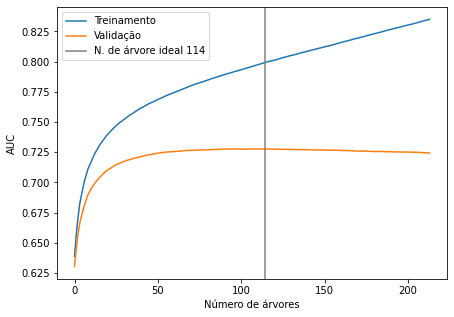

In [51]:
results     = model_best.evals_result()
ntree_limit = model_best.best_ntree_limit

plt.figure(figsize=(7,5))
plt.plot(results["validation_0"]["auc"], label="Treinamento")
plt.plot(results["validation_1"]["auc"], label="Validação")


plt.axvline(ntree_limit, 
            color="gray", 
            label="N. de árvore ideal {}".format(ntree_limit))

plt.xlabel("Número de árvores")
plt.ylabel("AUC")
plt.legend();

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Acima recuperamos as informações de treinamento do nosso modelo, podemos observar que o número de 1000 estimadores é mais que suficiente para o treinamento do modelo, o ideal é que fique em entre de 110 à 120 para esses dados e com a utilização dos parametros padrões que devem ser ajustados para o `XGB`. <br>
    
    
Vamos agora utilizar o modelo treinado que foi retornado pela função e vamos fazer a previsão para novos dados que o modelo não viu no treinamento, para termos uma ideia da generalização do modelo, lembrando que o modelo que foi treinado utiliza 1000 estimadores (arvores), sendo assim, vamos utilizar na previssão 114 estimadores utilizando o parametro `ntree_limit` ao fazermos as previsões.

</div>

In [52]:
X_valid_sc  = scaler.fit_transform(X_valid)

In [53]:
%%time

threshold   =.5
y_pred_prob = model_best.predict_proba(X_valid_sc,  ntree_limit=ntree_limit)[:, 1] 
y_pred      = (y_pred_prob > threshold).astype(int)

f1_    = metrics.f1_score(y_valid, y_pred)
auc_   = metrics.roc_auc_score(y_valid, y_pred_prob)
lloss_ = metrics.log_loss(y_valid, y_pred_prob) 
    
print('AUC     : {:2.5f}'.format(auc_))
print('F1-Score: {:2.5f}'.format(f1_))
print('L. Loss : {:2.5f}'.format(lloss_))
print()

AUC     : 0.72866
F1-Score: 0.69587
L. Loss : 0.61791

Wall time: 1.08 s


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>

No treinamento obtivemos uma AUC de 0.72913 e no dados de validação obtivemos uma AUC de 0.72866, temos uma pequena diferença, o que nos indica que o modelo consegue generalizar em dados não visto no treinamento.  
    
</div>

### 2.1.2. Curva ROC

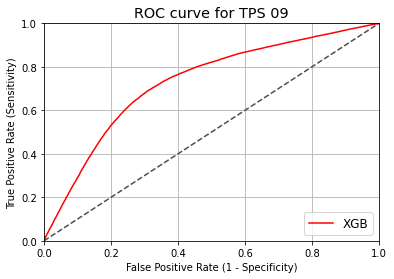

In [54]:
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_prob)

plot_roc_curve(fpr, tpr, label="XGB")
plt.show()

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
Observando a Curva ROC acima, podemos fazer alguns testes em relação ao ponto de corte, pois a AUC de 0.72866 tem um ponto de corte de 0.5 que é padrão, o que nos dar um F1-score de 0.69587, vamos fazer um gráfico de Matriz de Confusão para termos uma ideia melhor das previsões do modelo.  
    
</div>

### 2.1.3. Matriz de Confusão

#### 2.1.3.1. Com ponto de corte padrão

              precision    recall  f1-score   support

           0       0.69      0.68      0.68     59279
           1       0.69      0.70      0.70     60721

    accuracy                           0.69    120000
   macro avg       0.69      0.69      0.69    120000
weighted avg       0.69      0.69      0.69    120000


AUC     : 0.72866
F1-score: 0.69587


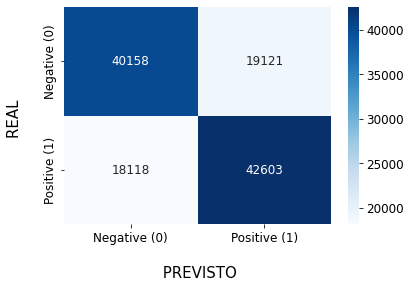

In [55]:
threshold    = .5
y_pred_valid = (y_pred_prob > threshold).astype(int)
f1_          = metrics.f1_score (y_valid, y_pred_valid)
auc_         = metrics.roc_auc_score(y_valid, y_pred_prob)

print(metrics.classification_report(y_valid, y_pred_valid))
print('')
print('AUC     : {:2.5f}'.format(auc_))
print('F1-score: {:2.5f}'.format(f1_))

confusion_plot(metrics.confusion_matrix(y_valid, y_pred) )

#### 2.1.3.2. Com ponto de corte

              precision    recall  f1-score   support

           0       0.72      0.55      0.63     59279
           1       0.65      0.79      0.71     60721

    accuracy                           0.68    120000
   macro avg       0.68      0.67      0.67    120000
weighted avg       0.68      0.68      0.67    120000


AUC     : 0.72866
F1-score: 0.71225


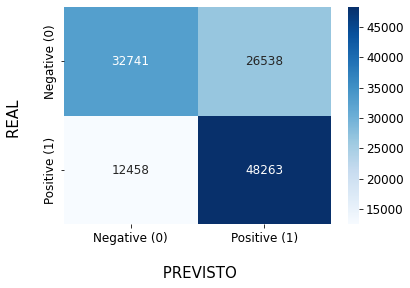

In [56]:
threshold    = .43
y_pred_valid = (y_pred_prob > threshold).astype(int)
f1_          = metrics.f1_score (y_valid, y_pred_valid)
auc_         = metrics.roc_auc_score(y_valid, y_pred_prob)

print(metrics.classification_report(y_valid, y_pred_valid))
print('')
print('AUC     : {:2.5f}'.format(auc_))
print('F1-score: {:2.5f}'.format(f1_))

confusion_plot(metrics.confusion_matrix(y_valid, y_pred_valid) )

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Com um ponto de corte de 0.43 temos um F1-score de 0.71225, passamos a acerta mais os falso positivos. 
    
</div>


### 2.1.3. Feature Importances  

In [57]:
feature_imp_     = model_best.feature_importances_

df               = pd.DataFrame()
df["Feature"]    = X.columns
df["Importance"] = feature_imp_ / feature_imp_.sum()

df.sort_values("Importance", axis=0, ascending=False, inplace=True)

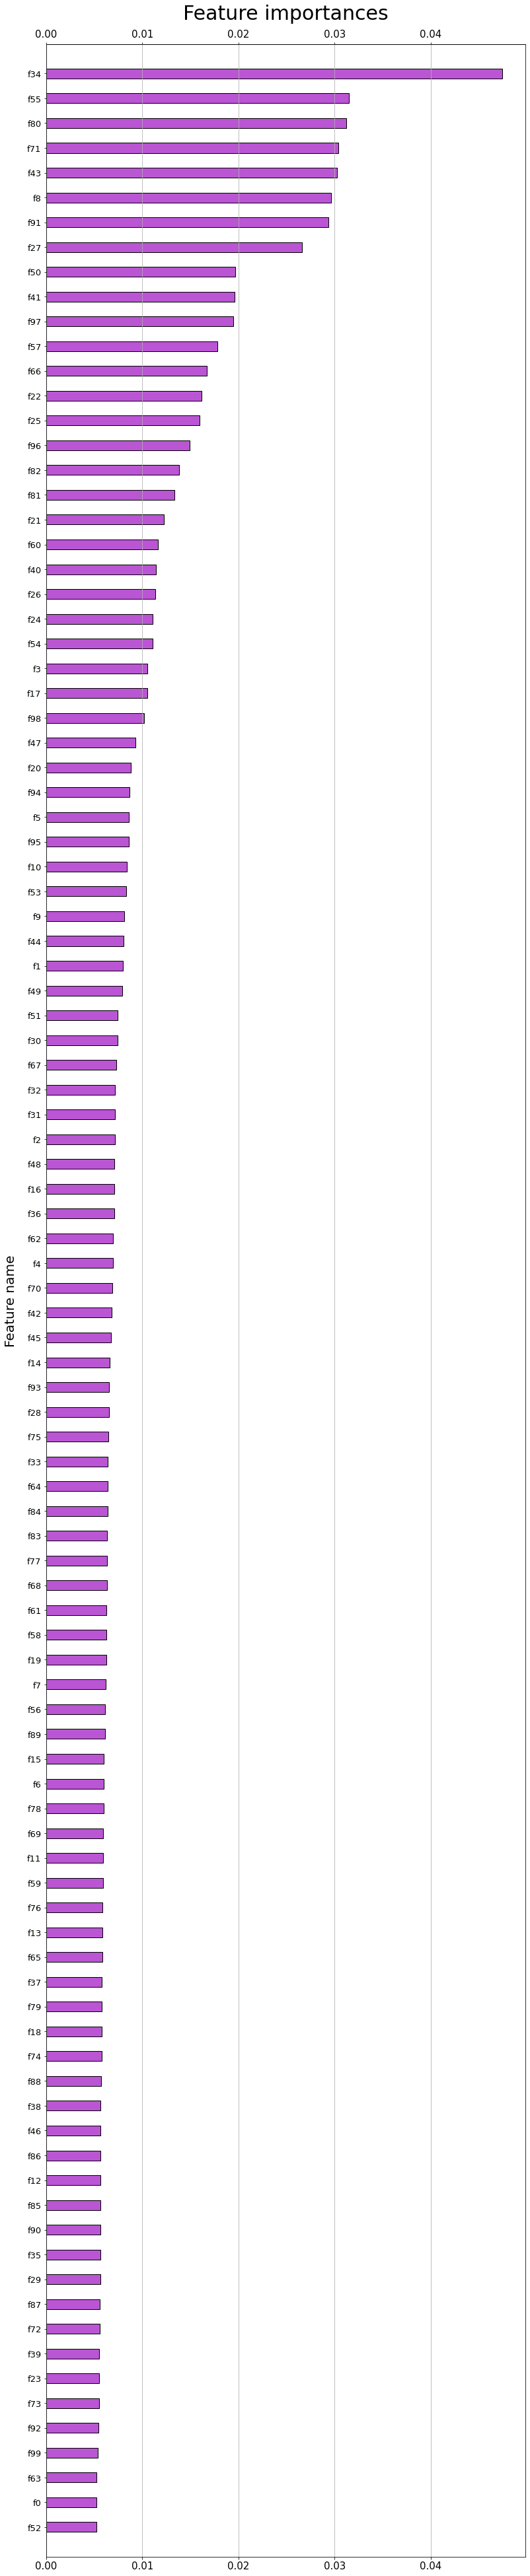

In [58]:
fig, ax = plt.subplots(figsize=(13, 70))
bars    = ax.barh(df["Feature"], 
                  df["Importance"], 
                  height    = 0.4,
                  color     = "mediumorchid", 
                  edgecolor = "black")

ax.set_title("Feature importances", fontsize=30, pad=15)
ax.set_ylabel("Feature name", fontsize=20, labelpad=15)
#ax.set_xlabel("Feature importance", fontsize=20, labelpad=15)
ax.set_yticks(df["Feature"])
ax.set_yticklabels(df["Feature"], fontsize=13)
ax.tick_params(axis="x", labelsize=15)
ax.grid(axis="x")

# Adicionando rótulos na parte superior
ax2 = ax.secondary_xaxis('top')
#ax2.set_xlabel("Feature importance", fontsize=20, labelpad=13)
ax2.tick_params(axis="x", labelsize=15)
ax.margins(0.05, 0.01)

# Inverter a direção do eixo y 
plt.gca().invert_yaxis()

# <div class="alert alert-success">  3. Conclusão </div> <br>

<div class="alert alert-info" role="alert"> 

Com este notebook fizemos uma pequena análise dos dados e identificamos que os dados disponíveis para a competição não segue uma distribuição normal, tem muitos outliers que precisam de um tratamento, nesta etapa utilizamos o XGB como modelo de linha de base e testamos diversos tipos de padronização de dados, o `QuatileTransforme` se mostrou o melhor padronizador com o XGB com a maioria dos parametros padrão.   

<br>     
No próximo notebook vamos criar novas variáveis para ajuda os modelos a identificar novos padrões nos dados e melhor AUC.  
   
<br>
    
Link notebook kaggle: https://www.kaggle.com/rogeriodelfim/tps-nov-2021-01-eda-baseline-xgb
    
    
</div>
